# ML Major project group 11

The task at hand is to come up with a machine learning model to predict the outcome of an IPL cricket match given some statistics such as batting averages, bowling averages, run rates, etc about the team. Data was web scraped from https://www.iplt20.com/stats/all-time for individual player statistics. Season wise match data was collected from kaggle. Since the percentage of matches which get tied are very small, they have not been considered for this model. Also, due the fact that a lot of teams changed dramatically in 2016, 17, these years were not included. Years 2008-12 were also not included because they were too far back to possibly make a meaningful prediction today. 2014-20 were used to train the model and 2013 was used as the test set. The reason for picking a completely different year as the test set was because this would be a good way to check how well the model generalizes to new teams and slightly different distrubutions because, in all probability, this model would be used to predict match outcomes for the following years. 

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import random
random.seed(20)



All csv files are read from the folder and then loaded into different data frames. They are all concatenated into a single data frame later 

In [5]:
df14=pd.read_csv("final14.csv",header=0)
df15=pd.read_csv("final15.csv",header=0)
df18=pd.read_csv("final18.csv",header=0)
df19=pd.read_csv("final19.csv",header=0)
df20=pd.read_csv("final20.csv",header=0)

In [6]:
df_matches=pd.concat([df14,df15,df18,df19,df20])

In [7]:
df_matches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284 entries, 0 to 51
Data columns (total 85 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Venue        277 non-null    object 
 1   Team 1       284 non-null    object 
 2   Team 2       284 non-null    object 
 3   Toss winner  284 non-null    int64  
 4   toss result  284 non-null    int64  
 5   res          284 non-null    int64  
 6   winner       284 non-null    int64  
 7   avg11        284 non-null    float64
 8   avg21        284 non-null    float64
 9   avg31        284 non-null    float64
 10  avg41        284 non-null    float64
 11  avg51        284 non-null    float64
 12  avg61        284 non-null    float64
 13  avg71        284 non-null    float64
 14  avg81        284 non-null    float64
 15  avg91        284 non-null    float64
 16  avg101       284 non-null    float64
 17  avg111       284 non-null    float64
 18  sr11         284 non-null    float64
 19  sr21     

<br>The model we are trying to build is provided with the the following features. 
* The batting averages and strike rates of all 11 batsmen of team 1 and 2
* The bowling averages and economies of 7 bowlers of team 1 and 2
* The win and lost count of team 1 and team 2
* The team which won the toss
* The toss decision (field or bat)
* The net run rate for team 1 and 2


The model does not attempt to learn data based on how many matches a specific team has played / won against another specific team. Rather, it attempts to learn a set of features each team must posses to win or lose.

***Therefore, this is being handled as a binary classification problem***

Venue has not been included as a feature because a lot of the matches were out of the country where neither of the teams had the home advantage

In [8]:
df_matches_model=df_matches.drop(['Venue','Team 1','Team 2','res'],axis=1)

In [9]:
df_matches_model.head()

,Toss winner,toss result,winner,avg11,avg21,avg31,avg41,avg51,avg61,avg71,...,econ12,econ22,econ32,econ42,econ52,econ62,econ72,won2,lost2,rr2
0,0,1,0,44.00,32.80,32.42,30.84,29.77,29.00,25.16,...,6.45,8.00,8.07,6.47,8.66,6.50,6.53,7.0,7.0,0.095
1,1,0,1,51.25,30.40,29.80,29.40,23.21,21.85,19.66,...,8.15,10.27,7.49,7.87,7.01,6.16,8.25,5.0,9.0,-0.428
2,0,1,1,74.20,58.00,40.23,35.37,31.15,29.20,27.54,...,8.20,8.81,6.13,8.79,8.29,7.71,10.50,11.0,3.0,0.968
3,1,0,1,48.00,38.66,29.00,28.09,27.50,23.66,20.75,...,5.37,7.11,7.62,7.85,7.44,7.26,9.66,7.0,7.0,0.060
4,1,0,1,56.28,34.12,30.00,29.44,25.78,23.22,17.28,...,8.15,10.27,7.49,7.87,7.01,6.16,8.25,5.0,9.0,-0.428


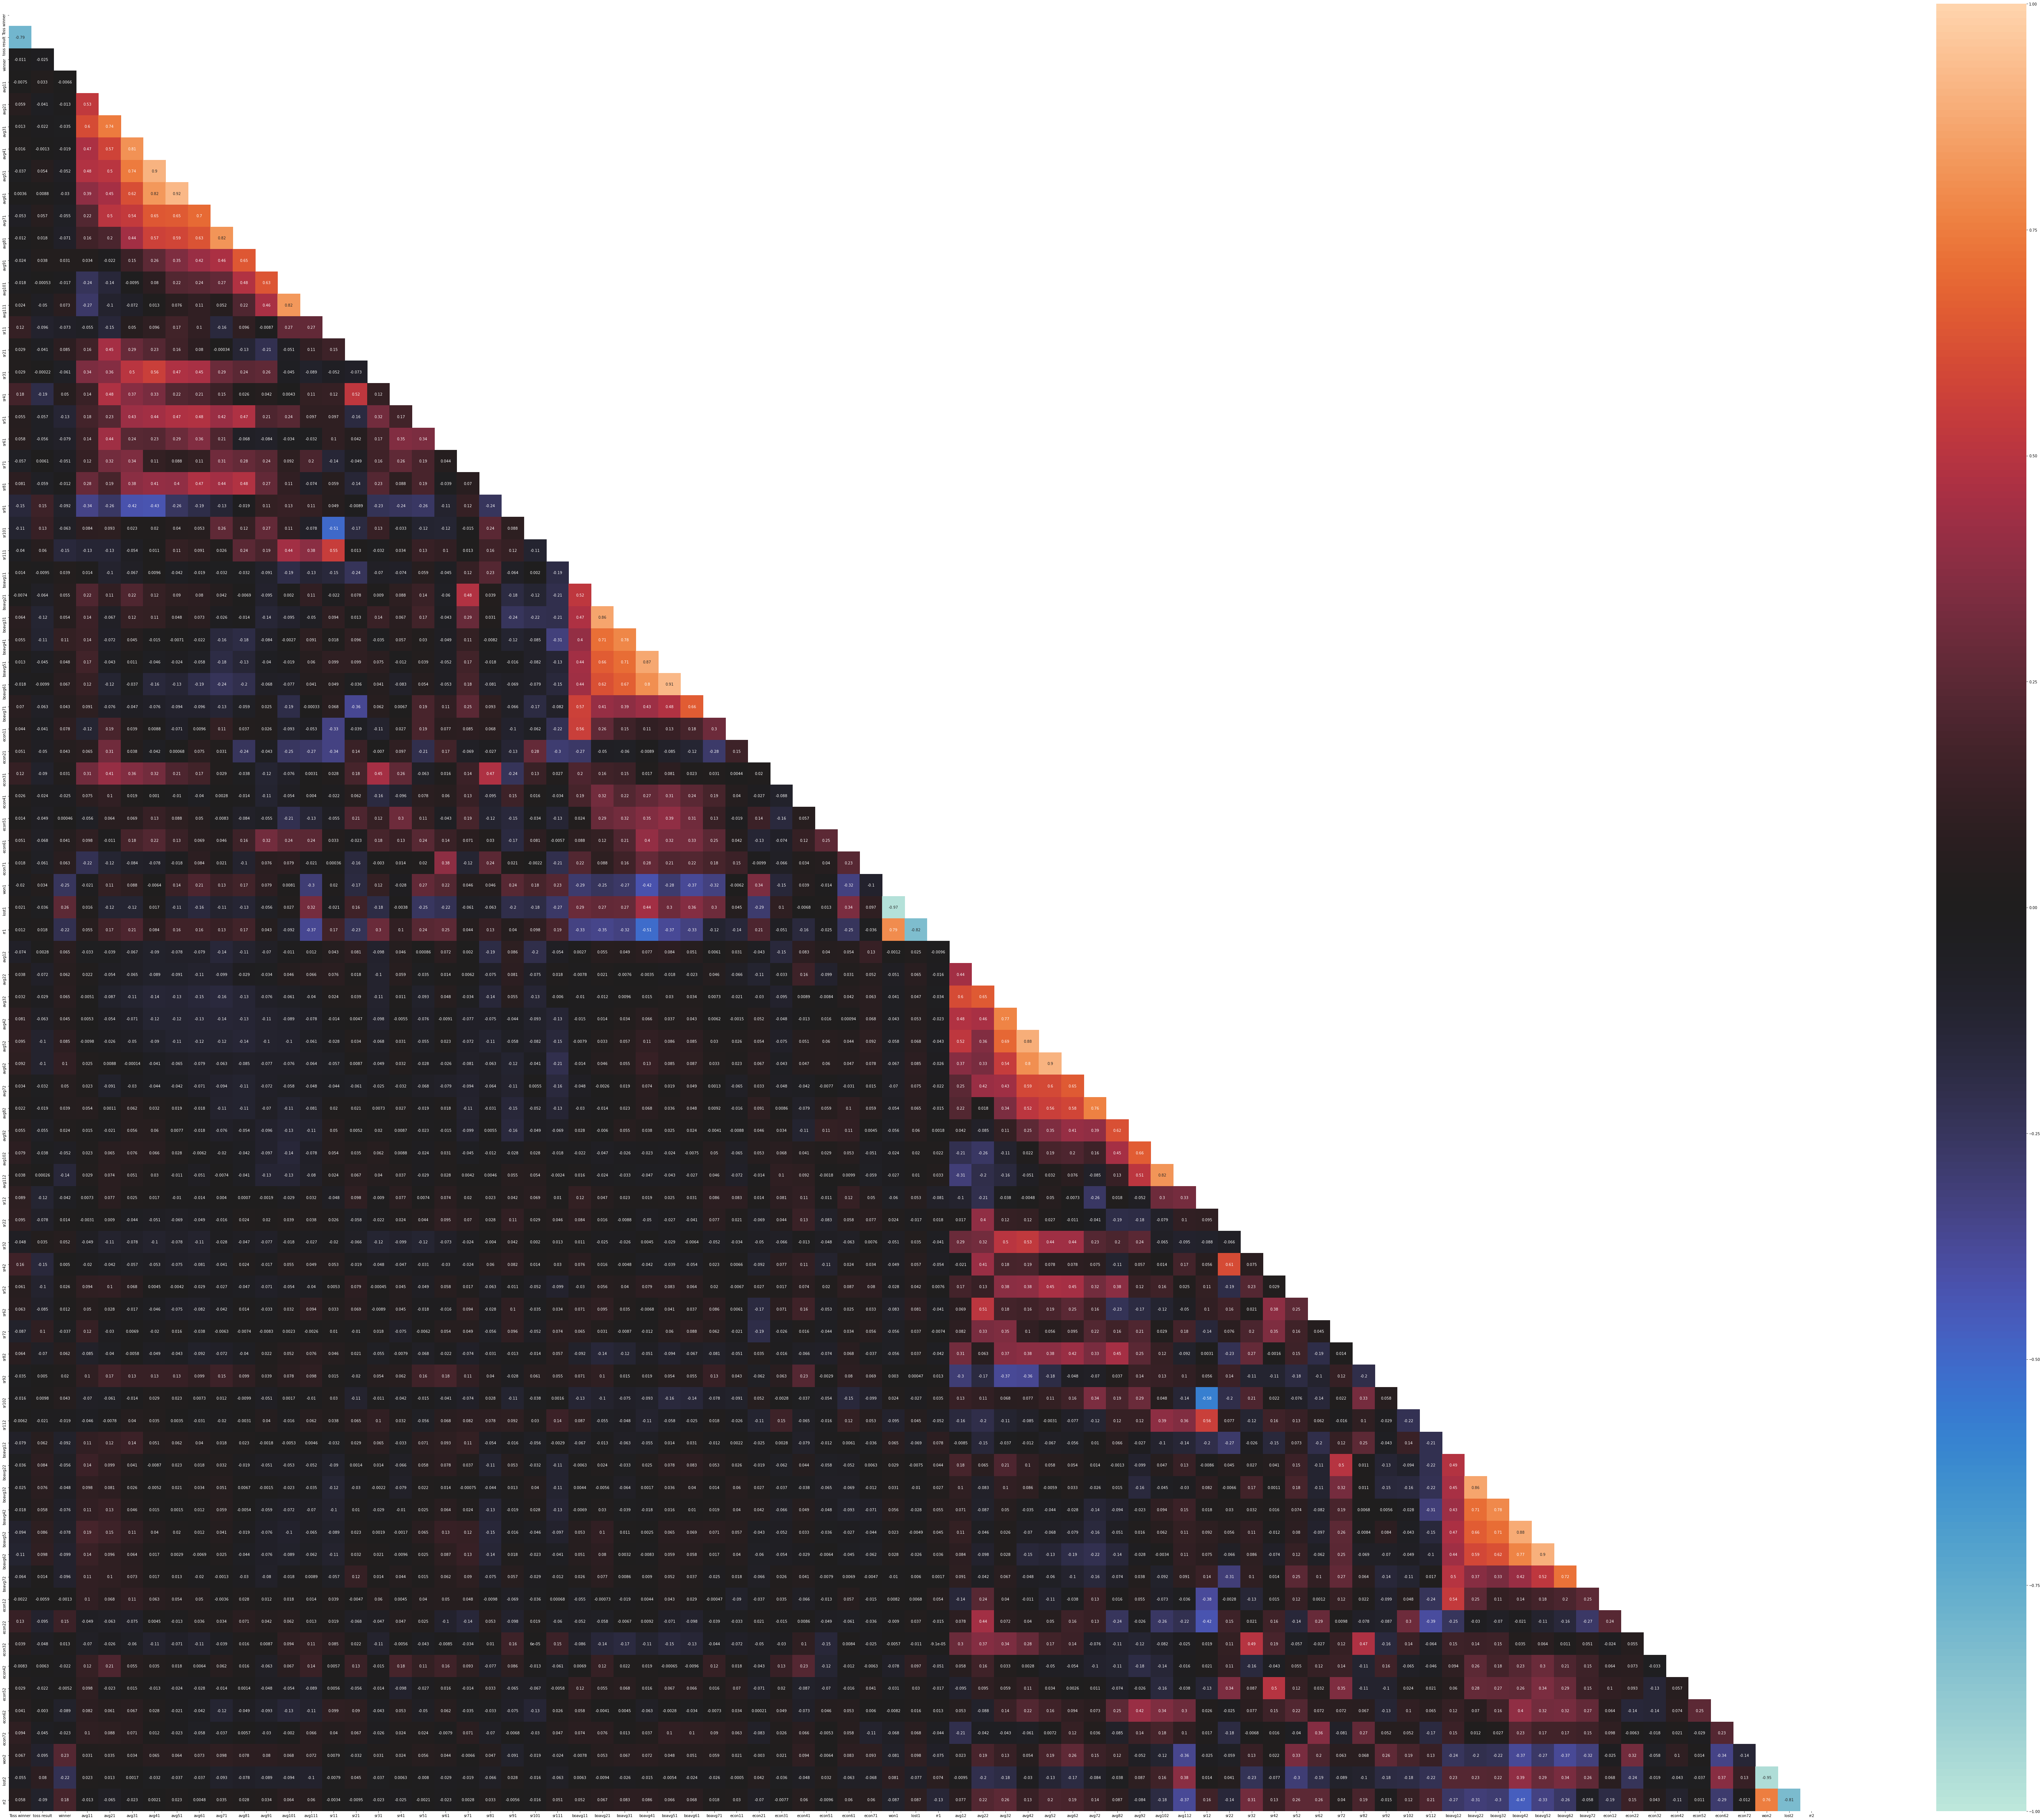

In [10]:
corr=np.triu(df_matches_model.corr())


f,ax=plt.subplots(figsize=(110,90))

sns.heatmap(df_matches_model.corr(),annot=True,vmin=-1,vmax=1,center=0,mask=corr)
plt.show()

<br>For this problem, 5 algorithms have been chosen after a lot of consideration about the nature of the problem and the data. They are:
* Gaussian Naive Bayes
* Random Forest
* Simple Logistic Regression 
* SVM with an RBF Kernel 
* XGBoost

<br>Additionally, PCA was used in combination with all possible model structures as well to hopefully improve performance<br>

All of the 5 listed algorithms are run on all chosen model structures. All of the structures were chosen based on some form of prior knowledge about the game and the relative importance of each player. ***5 fold cross validation was used with accuracy as the metric***. Other metrics such as roc auc were not considered because they are meant for classes which deal with positive/negative classes. While this is being handled as a binary classification problem, the initial proposition was to handle this as multi class for which the other metrics would not work so well. Besides, as this is not a skewed class problem, accuracy with k fold cross validation gave a good idea of how well the model was generalising to new data sets as well

Note: Comparison of accuracy across multiple cells is done relative to the best model structure. In some cells (most of the cells represent a model structure each. Exceptions have been specified if not self evident), certain models like logistic regression might see a 10% jump in accuracy. However, it often turned out that that one of the 4 algorithms showing a significant improvement still did not do better than the best algorithm from the previous model structure. So, for one model structure (feature selection/feature scaling) to be better than another, it is not necessary that all algorithms should do better than the other model. 
Therefore, the following comparison metric was used to compare 2 model structures. 

***For model structure A to be called superior to model structure B, there must exist at least one algorithm that ran on model structure A that outperformed all algorithms on model structure B, i.e.***

***
$structA$ $>$ $structB$ iff  $\exists$  $i$   $\ni$    $algorithm_i(structA)$  > max ($algorithm_j(structB)$) $\forall$ $j$
***

In [24]:
#this function will train models corresponding to all 5 algorithms on 5 fold cross validation
def run_models (X,y):
    gnb=GaussianNB()
    gnb.fit(X,y)
    acc_nb=cross_val_score(gnb,X,y,scoring='accuracy')
    print("Naive Bayes:",np.mean(acc_nb))

    rf=RandomForestClassifier(class_weight='balanced',n_estimators=200)
    rf.fit(X,y)
    acc_rf=cross_val_score(rf,X,y,scoring='accuracy')
    print("Random Forest:",np.mean(acc_rf))

    lr=LogisticRegression(max_iter=8000,class_weight='balanced')
    lr.fit(X,y)
    acc_lr=cross_val_score(lr,X,y,scoring='accuracy')
    print("Logistic Regression:",np.mean(acc_lr))

    svc=SVC()
    svc.fit(X,y)
    acc_svc=cross_val_score(svc,X,y,scoring='accuracy')
    print("SVM:",np.mean(acc_svc))

    xgb=XGBClassifier()
    xgb.fit(X,y)
    acc_xgb=cross_val_score(xgb,X,y,scoring='accuracy')
    print("XGB:",np.mean(acc_xgb))
    
    return acc_nb,acc_rf,acc_lr,acc_svc,acc_xgb

<br>***The first structure is the raw X and y data***. We run all 5 algorithms Vanilla and Naive Bayes outperforms all algorithms.

In [26]:
#vanilla

X=df_matches_model.drop(['winner'],axis=1)
y=df_matches_model['winner']
run_models(X,y)

print('\nWith pca')
pca=PCA()
X=pca.fit_transform(X)
run_models(X,y);


Naive Bayes: 0.5844611528822055
Random Forest: 0.5669799498746867
Logistic Regression: 0.5209273182957393
SVM: 0.56328320802005
XGB: 0.5528822055137844

With pca
Naive Bayes: 0.6053884711779448
Random Forest: 0.6055764411027569
Logistic Regression: 0.5139097744360903
SVM: 0.5671679197994987
XGB: 0.5881578947368421


<br><br>The following cells were run based on the results of the correlation matrix. Highly correlated features were removed with the hope of improving the accuracy. This slightly improved the accuracy for Naive Bayes but better approaches were found and have been described later. Furthermore, the correlation of the features win and lost was -0.97. But removing the lost feature dropped the accuracy of the model on average by atleast 3-4 % and therefore, it was evident that ***removing correlated features was not the way go***

In [27]:
X=df_matches_model.drop(['winner','avg51','sr11','boavg31','boavg51','boavg32','avg112','avg52','boavg52'],axis=1)
y=df_matches_model['winner']

run_models(X,y)

print('\nWith pca')
pca=PCA()
X=pca.fit_transform(X)

run_models(X,y);
#correlation 1

Naive Bayes: 0.5984335839598998
Random Forest: 0.5563283208020051
Logistic Regression: 0.5070175438596491
SVM: 0.5527568922305764
XGB: 0.5352756892230577

With pca
Naive Bayes: 0.5245614035087719
Random Forest: 0.5494987468671679
Logistic Regression: 0.5350877192982455
SVM: 0.581077694235589
XGB: 0.5423558897243108


In [28]:
X=df_matches_model.drop(['winner','avg51','boavg51','avg52','boavg52'],axis=1)
y=df_matches_model['winner']

run_models(X,y)

print('\nWith pca')
pca=PCA()
X=pca.fit_transform(X)
run_models(X,y);
#attempt to remove based on correlation. Reduction in performance 


Naive Bayes: 0.587907268170426
Random Forest: 0.5598997493734336
Logistic Regression: 0.5351503759398496
SVM: 0.56328320802005
XGB: 0.5458020050125313

With pca
Naive Bayes: 0.5842731829573935
Random Forest: 0.5740601503759398
Logistic Regression: 0.5351503759398496
SVM: 0.5671679197994987
XGB: 0.5599624060150376


<br> The following 2 cells run all 4 algorithms with feature scaling (Standard Scaler and  MinMaxScaler on X). ***Running feature scaling on the data without modifying the model structure did not improve the accuracy substantially***

In [29]:
#standard scaler
print('Standard Scaler')
X=df_matches_model.drop(['winner'],axis=1)
scaler=StandardScaler()
X=scaler.fit_transform(X)

run_models(X,y)
print('\nWith pca')
pca=PCA()
X=pca.fit_transform(X)
run_models(X,y);

Standard Scaler
Naive Bayes: 0.5844611528822055
Random Forest: 0.5635338345864662
Logistic Regression: 0.5704260651629072
SVM: 0.5917293233082707
XGB: 0.5528822055137844

With pca
Naive Bayes: 0.5280075187969925
Random Forest: 0.5562030075187969
Logistic Regression: 0.5704260651629072
SVM: 0.5917293233082707
XGB: 0.5421679197994987


In [30]:
print('\nMinMaxScaler')
X=df_matches_model.drop(['winner'],axis=1)
scaler=MinMaxScaler()
X=scaler.fit_transform(X)
run_models(X,y)
print('\nWith pca')
pca=PCA()
X=pca.fit_transform(X)
run_models(X,y);


MinMaxScaler
Naive Bayes: 0.5844611528822055
Random Forest: 0.5953007518796992
Logistic Regression: 0.581077694235589
SVM: 0.5882205513784461
XGB: 0.5528822055137844

With pca
Naive Bayes: 0.5317669172932332
Random Forest: 0.5278822055137845
Logistic Regression: 0.581077694235589
SVM: 0.5741228070175438
XGB: 0.5807644110275689


After having tried quite a few models on the raw data, it became clear that ***feature selection was necessary to further improve model accuracy***. This is what has been attempted in the following cells

The first cell runs all the 5 algorithms on all possible structures (77). The second also runs PCA before running the 5 algorithms.

In [31]:
maxAccNb=int(0)
mbaNb=int(0)
mbbNb=int(0)

maxAccRf=int(0)
mbaRf=int(0)
mbbRf=int(0)

maxAccLr=int(0)
mbaLr=int(0)
mbbLr=int(0)

maxAccSVM=int(0)
mbaSVM=int(0)
mbbSVM=int(0)

maxAccXGB=int(0)
mbaXBB=int(0)
mbbXGB=int(0)

for batcount in range(1,12):
    for bowlcount in range(1,8):
        
        team=0
        list0=['Toss winner','toss result','won1','lost1','rr1','won2','lost2','rr2']
        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('avg'+x)
        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('sr'+x)
        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('boavg'+x)
        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('econ'+x)

        team=1


        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('avg'+x)
        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('sr'+x)
        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('boavg'+x)
        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('econ'+x)


        
        X=df_matches_model[list0]
        y=df_matches_model['winner']
        

        print("\nBatsman bowler count:",' ',batcount,' ',bowlcount)
        acc_nb,acc_rf,acc_lr,acc_svc,acc_xgb=run_models(X,y)
        
        if (maxAccNb<np.mean(acc_nb)):
            maxAccNb=np.mean(acc_nb)
            mbaNb=batcount
            mbbNb=bowlcount
            
        if (maxAccRf<np.mean(acc_rf)):
            maxAccRf=np.mean(acc_rf)
            mbaRf=batcount
            mbbRf=bowlcount
            
        if (maxAccLr<np.mean(acc_lr)):
            maxAccLr=np.mean(acc_lr)
            mbaLr=batcount
            mbbLr=bowlcount
            
        if (maxAccSVM<np.mean(acc_svc)):
            maxAccSVM=np.mean(acc_svc)
            mbaSVM=batcount
            mbbSVM=bowlcount
            
        if (maxAccXGB<np.mean(acc_xgb)):
            maxAccXGB=np.mean(acc_xgb)
            mbaXGB=batcount
            mbbXGB=bowlcount
        #print(batcount,' ',bowlcount,'\n')
    
print ("\nbest NB:",maxAccNb,' ',mbaNb,' ',mbbNb)
print ("best RF:",maxAccRf,' ',mbaRf,' ',mbbRf)
print ("best LR:",maxAccLr,' ',mbaLr,' ',mbbLr)
print ("best SVM:",maxAccSVM,' ',mbaSVM,' ',mbbSVM)
print ("best XGB:",maxAccXGB,' ',mbaXGB,' ',mbbXGB)


Batsman bowler count:   1   1
Naive Bayes: 0.6444235588972431
Random Forest: 0.5845238095238096
Logistic Regression: 0.6057017543859649
SVM: 0.5422305764411027
XGB: 0.5773182957393483

Batsman bowler count:   1   2
Naive Bayes: 0.6265664160401002
Random Forest: 0.5845238095238096
Logistic Regression: 0.6444235588972431
SVM: 0.5422305764411027
XGB: 0.5775689223057644

Batsman bowler count:   1   3
Naive Bayes: 0.6370927318295738
Random Forest: 0.6092731829573934
Logistic Regression: 0.5951754385964912
SVM: 0.5422305764411027
XGB: 0.5739348370927319

Batsman bowler count:   1   4
Naive Bayes: 0.6054511278195489
Random Forest: 0.5669172932330827
Logistic Regression: 0.5773182957393483
SVM: 0.5422305764411027
XGB: 0.5455513784461152

Batsman bowler count:   1   5
Naive Bayes: 0.5912280701754387
Random Forest: 0.5632205513784461
Logistic Regression: 0.5773182957393483
SVM: 0.5422305764411027
XGB: 0.5454260651629073

Batsman bowler count:   1   6
Naive Bayes: 0.5949248120300752
Random Fores

Logistic Regression: 0.5773809523809523
SVM: 0.5422305764411027
XGB: 0.5491228070175438

Batsman bowler count:   7   4
Naive Bayes: 0.612781954887218
Random Forest: 0.5494987468671679
Logistic Regression: 0.5984335839598998
SVM: 0.5422305764411027
XGB: 0.5490601503759399

Batsman bowler count:   7   5
Naive Bayes: 0.6021303258145363
Random Forest: 0.5742481203007519
Logistic Regression: 0.5593984962406015
SVM: 0.5422305764411027
XGB: 0.5421052631578946

Batsman bowler count:   7   6
Naive Bayes: 0.6268170426065163
Random Forest: 0.5739974937343358
Logistic Regression: 0.5453634085213033
SVM: 0.5422305764411027
XGB: 0.5421052631578946

Batsman bowler count:   7   7
Naive Bayes: 0.6231829573934837
Random Forest: 0.580952380952381
Logistic Regression: 0.5384711779448622
SVM: 0.5422305764411027
XGB: 0.5843358395989975

Batsman bowler count:   8   1
Naive Bayes: 0.6057017543859649
Random Forest: 0.5952380952380952
Logistic Regression: 0.5738721804511279
SVM: 0.5422305764411027
XGB: 0.535150

In [32]:
print("With PCA")
maxAccNb=int(0)
mbaNb=int(0)
mbbNb=int(0)

maxAccRf=int(0)
mbaRf=int(0)
mbbRf=int(0)

maxAccLr=int(0)
mbaLr=int(0)
mbbLr=int(0)

maxAccSVM=int(0)
mbaSVM=int(0)
mbbSVM=int(0)

maxAccXGB=int(0)
mbaXBB=int(0)
mbbXGB=int(0)

for batcount in range(1,12):
    for bowlcount in range(1,8):
        
        team=0
        list0=['Toss winner','toss result','won1','lost1','rr1','won2','lost2','rr2']
        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('avg'+x)
        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('sr'+x)
        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('boavg'+x)
        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('econ'+x)

        team=1


        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('avg'+x)
        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('sr'+x)
        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('boavg'+x)
        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('econ'+x)


        
        X=df_matches_model[list0]
        y=df_matches_model['winner']
        pca=PCA()
        X=pca.fit_transform(X)

        print("\nBatsman bowler count:",' ',batcount,' ',bowlcount)
        acc_nb,acc_rf,acc_lr,acc_svc,acc_xgb=run_models(X,y)
        
        if (maxAccNb<np.mean(acc_nb)):
            maxAccNb=np.mean(acc_nb)
            mbaNb=batcount
            mbbNb=bowlcount
            
        if (maxAccRf<np.mean(acc_rf)):
            maxAccRf=np.mean(acc_rf)
            mbaRf=batcount
            mbbRf=bowlcount
            
        if (maxAccLr<np.mean(acc_lr)):
            maxAccLr=np.mean(acc_lr)
            mbaLr=batcount
            mbbLr=bowlcount
            
        if (maxAccSVM<np.mean(acc_svc)):
            maxAccSVM=np.mean(acc_svc)
            mbaSVM=batcount
            mbbSVM=bowlcount
            
        if (maxAccXGB<np.mean(acc_xgb)):
            maxAccXGB=np.mean(acc_xgb)
            mbaXGB=batcount
            mbbXGB=bowlcount
        #print(batcount,' ',bowlcount,'\n')
    
print ("\nbest NB+PCA:",maxAccNb,' ',mbaNb,' ',mbbNb)
print ("best RF+PCA:",maxAccRf,' ',mbaRf,' ',mbbRf)
print ("best LR+PCA:",maxAccLr,' ',mbaLr,' ',mbbLr)
print ("best SVM+PCA:",maxAccSVM,' ',mbaSVM,' ',mbbSVM)
print ("best XGB+PCA:",maxAccXGB,' ',mbaXGB,' ',mbbXGB)

With PCA

Batsman bowler count:   1   1
Naive Bayes: 0.5879072681704262
Random Forest: 0.5949248120300752
Logistic Regression: 0.6022556390977443
SVM: 0.5282581453634085
XGB: 0.563345864661654

Batsman bowler count:   1   2
Naive Bayes: 0.6021929824561404
Random Forest: 0.6020676691729323
Logistic Regression: 0.6444235588972431
SVM: 0.5212406015037594
XGB: 0.6476190476190476

Batsman bowler count:   1   3
Naive Bayes: 0.6057017543859649
Random Forest: 0.5983709273182958
Logistic Regression: 0.6058270676691728
SVM: 0.5282581453634085
XGB: 0.54937343358396

Batsman bowler count:   1   4
Naive Bayes: 0.5916040100250627
Random Forest: 0.5844611528822055
Logistic Regression: 0.5773182957393483
SVM: 0.5422932330827068
XGB: 0.5668546365914787

Batsman bowler count:   1   5
Naive Bayes: 0.5843984962406015
Random Forest: 0.5739974937343358
Logistic Regression: 0.5703007518796992
SVM: 0.549310776942356
XGB: 0.5704887218045113

Batsman bowler count:   1   6
Naive Bayes: 0.5740601503759398
Random 

Logistic Regression: 0.5632205513784461
SVM: 0.531704260651629
XGB: 0.5179197994987469

Batsman bowler count:   7   4
Naive Bayes: 0.5842731829573935
Random Forest: 0.5773809523809523
Logistic Regression: 0.5913533834586466
SVM: 0.5387844611528821
XGB: 0.5314536340852131

Batsman bowler count:   7   5
Naive Bayes: 0.5350250626566416
Random Forest: 0.5420426065162907
Logistic Regression: 0.5771929824561404
SVM: 0.5423558897243106
XGB: 0.5244360902255639

Batsman bowler count:   7   6
Naive Bayes: 0.5350877192982456
Random Forest: 0.5563909774436089
Logistic Regression: 0.5382832080200501
SVM: 0.5388471177944861
XGB: 0.500250626566416

Batsman bowler count:   7   7
Naive Bayes: 0.5387844611528821
Random Forest: 0.5035087719298245
Logistic Regression: 0.5314536340852131
SVM: 0.5738095238095238
XGB: 0.4892857142857143

Batsman bowler count:   8   1
Naive Bayes: 0.6055137844611529
Random Forest: 0.5595864661654135
Logistic Regression: 0.5773809523809523
SVM: 0.5246867167919799
XGB: 0.559586

The above cells picked a very small number of features. This could possibly be because picking a larger number of features resulted in overfitting which performed poorly on cross validation. However, based on prior knowledge of the game, it is unrealistic to predict the outcome of a cricket match based on just the top 2 or 3 batsmen or bowlers. It is possible that these models also overfit the cross validation set and while they ended up performing better on average, they cannot be expected to generalize well to the test set

<br>Given the fact that scaling seemed to improve model accuracy, ***the following cell run all the algorithms with the StandardScaler. But Naive Bayes is not affected by scaling. The cell after that does the same thing but with a MinMaxScaler***

In [33]:
maxAccNb=int(0)
mbaNb=int(0)
mbbNb=int(0)

maxAccRf=int(0)
mbaRf=int(0)
mbbRf=int(0)

maxAccLr=int(0)
mbaLr=int(0)
mbbLr=int(0)

maxAccSVM=int(0)
mbaSVM=int(0)
mbbSVM=int(0)

maxAccXGB=int(0)
mbaXBB=int(0)
mbbXGB=int(0)

for batcount in range(1,12):
    for bowlcount in range(1,8):
        
        team=0
        list0=['Toss winner','toss result','won1','lost1','rr1','won2','lost2','rr2']
        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('avg'+x)
        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('sr'+x)
        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('boavg'+x)
        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('econ'+x)

        team=1


        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('avg'+x)
        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('sr'+x)
        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('boavg'+x)
        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('econ'+x)


        
        X=df_matches_model[list0]
        y=df_matches_model['winner']
        scaler=StandardScaler()
        X=scaler.fit_transform(X)

        print("\nBatsman bowler count:",' ',batcount,' ',bowlcount)
        acc_nb,acc_rf,acc_lr,acc_svc,acc_xgb=run_models(X,y)
        
        if (maxAccNb<np.mean(acc_nb)):
            maxAccNb=np.mean(acc_nb)
            mbaNb=batcount
            mbbNb=bowlcount
            
        if (maxAccRf<np.mean(acc_rf)):
            maxAccRf=np.mean(acc_rf)
            mbaRf=batcount
            mbbRf=bowlcount
            
        if (maxAccLr<np.mean(acc_lr)):
            maxAccLr=np.mean(acc_lr)
            mbaLr=batcount
            mbbLr=bowlcount
            
        if (maxAccSVM<np.mean(acc_svc)):
            maxAccSVM=np.mean(acc_svc)
            mbaSVM=batcount
            mbbSVM=bowlcount
            
        if (maxAccXGB<np.mean(acc_xgb)):
            maxAccXGB=np.mean(acc_xgb)
            mbaXGB=batcount
            mbbXGB=bowlcount
        #print(batcount,' ',bowlcount,'\n')
    
print ("\nbest NB:",maxAccNb,' ',mbaNb,' ',mbbNb)
print ("best RF:",maxAccRf,' ',mbaRf,' ',mbbRf)
print ("best LR:",maxAccLr,' ',mbaLr,' ',mbbLr)
print ("best SVM:",maxAccSVM,' ',mbaSVM,' ',mbbSVM)
print ("best XGB:",maxAccXGB,' ',mbaXGB,' ',mbbXGB)


Batsman bowler count:   1   1
Naive Bayes: 0.6444235588972431
Random Forest: 0.5843984962406015
Logistic Regression: 0.6092731829573934
SVM: 0.6020050125313283
XGB: 0.5773182957393483

Batsman bowler count:   1   2
Naive Bayes: 0.6265664160401002
Random Forest: 0.6092105263157894
Logistic Regression: 0.6303884711779448
SVM: 0.5986215538847117
XGB: 0.5775689223057644

Batsman bowler count:   1   3
Naive Bayes: 0.6370927318295738
Random Forest: 0.5669799498746867
Logistic Regression: 0.6093358395989975
SVM: 0.6057644110275688
XGB: 0.5739348370927319

Batsman bowler count:   1   4
Naive Bayes: 0.6054511278195489
Random Forest: 0.5845864661654134
Logistic Regression: 0.5702380952380952
SVM: 0.5843984962406015
XGB: 0.5455513784461152

Batsman bowler count:   1   5
Naive Bayes: 0.5912280701754387
Random Forest: 0.5738721804511279
Logistic Regression: 0.5845238095238094
SVM: 0.5775062656641604
XGB: 0.5454260651629073

Batsman bowler count:   1   6
Naive Bayes: 0.5949248120300752
Random Fores

XGB: 0.5491228070175438

Batsman bowler count:   7   4
Naive Bayes: 0.612781954887218
Random Forest: 0.5812030075187969
Logistic Regression: 0.5949248120300752
SVM: 0.6337719298245614
XGB: 0.5490601503759399

Batsman bowler count:   7   5
Naive Bayes: 0.6021303258145363
Random Forest: 0.563345864661654
Logistic Regression: 0.5913533834586466
SVM: 0.6266917293233083
XGB: 0.5421052631578946

Batsman bowler count:   7   6
Naive Bayes: 0.6268170426065163
Random Forest: 0.5845864661654135
Logistic Regression: 0.5454887218045112
SVM: 0.6374686716791981
XGB: 0.5491228070175438

Batsman bowler count:   7   7
Naive Bayes: 0.6231829573934837
Random Forest: 0.5703007518796992
Logistic Regression: 0.5630952380952381
SVM: 0.6338345864661654
XGB: 0.5843358395989975

Batsman bowler count:   8   1
Naive Bayes: 0.6057017543859649
Random Forest: 0.6057644110275688
Logistic Regression: 0.5667293233082706
SVM: 0.6196741854636592
XGB: 0.5351503759398496

Batsman bowler count:   8   2
Naive Bayes: 0.6233709

In [34]:
maxAccNb=int(0)
mbaNb=int(0)
mbbNb=int(0)

maxAccRf=int(0)
mbaRf=int(0)
mbbRf=int(0)

maxAccLr=int(0)
mbaLr=int(0)
mbbLr=int(0)

maxAccSVM=int(0)
mbaSVM=int(0)
mbbSVM=int(0)

maxAccXGB=int(0)
mbaXBB=int(0)
mbbXGB=int(0)

for batcount in range(1,12):
    for bowlcount in range(1,8):
        
        team=0
        list0=['Toss winner','toss result','won1','lost1','rr1','won2','lost2','rr2']
        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('avg'+x)
        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('sr'+x)
        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('boavg'+x)
        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('econ'+x)

        team=1


        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('avg'+x)
        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('sr'+x)
        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('boavg'+x)
        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('econ'+x)


        
        X=df_matches_model[list0]
        y=df_matches_model['winner']
        scaler=MinMaxScaler()
        X=scaler.fit_transform(X)

        print("\nBatsman bowler count:",' ',batcount,' ',bowlcount)
        acc_nb,acc_rf,acc_lr,acc_svc,acc_xgb=run_models(X,y)
        
        if (maxAccNb<np.mean(acc_nb)):
            maxAccNb=np.mean(acc_nb)
            mbaNb=batcount
            mbbNb=bowlcount
            
        if (maxAccRf<np.mean(acc_rf)):
            maxAccRf=np.mean(acc_rf)
            mbaRf=batcount
            mbbRf=bowlcount
            
        if (maxAccLr<np.mean(acc_lr)):
            maxAccLr=np.mean(acc_lr)
            mbaLr=batcount
            mbbLr=bowlcount
            
        if (maxAccSVM<np.mean(acc_svc)):
            maxAccSVM=np.mean(acc_svc)
            mbaSVM=batcount
            mbbSVM=bowlcount
            
        if (maxAccXGB<np.mean(acc_xgb)):
            maxAccXGB=np.mean(acc_xgb)
            mbaXGB=batcount
            mbbXGB=bowlcount
        #print(batcount,' ',bowlcount,'\n')
    
print ("\nbest NB:",maxAccNb,' ',mbaNb,' ',mbbNb)
print ("best RF:",maxAccRf,' ',mbaRf,' ',mbbRf)
print ("best LR:",maxAccLr,' ',mbaLr,' ',mbbLr)
print ("best SVM:",maxAccSVM,' ',mbaSVM,' ',mbbSVM)
print ("best XGB:",maxAccXGB,' ',mbaXGB,' ',mbbXGB)


Batsman bowler count:   1   1
Naive Bayes: 0.6444235588972431
Random Forest: 0.581077694235589
Logistic Regression: 0.6163533834586467
SVM: 0.5668546365914787
XGB: 0.5773182957393483

Batsman bowler count:   1   2
Naive Bayes: 0.6265664160401002
Random Forest: 0.5774436090225563
Logistic Regression: 0.6478070175438596
SVM: 0.581015037593985
XGB: 0.5775689223057644

Batsman bowler count:   1   3
Naive Bayes: 0.6370927318295738
Random Forest: 0.5952380952380951
Logistic Regression: 0.6373433583959899
SVM: 0.5915413533834586
XGB: 0.5739348370927319

Batsman bowler count:   1   4
Naive Bayes: 0.6054511278195489
Random Forest: 0.5775062656641604
Logistic Regression: 0.6092731829573934
SVM: 0.5633458646616543
XGB: 0.5455513784461152

Batsman bowler count:   1   5
Naive Bayes: 0.5912280701754387
Random Forest: 0.581140350877193
Logistic Regression: 0.5953007518796992
SVM: 0.5526942355889723
XGB: 0.5454260651629073

Batsman bowler count:   1   6
Naive Bayes: 0.5949248120300752
Random Forest: 

XGB: 0.5491228070175438

Batsman bowler count:   7   4
Naive Bayes: 0.612781954887218
Random Forest: 0.5881578947368421
Logistic Regression: 0.5951127819548871
SVM: 0.6056390977443609
XGB: 0.5490601503759399

Batsman bowler count:   7   5
Naive Bayes: 0.6021303258145363
Random Forest: 0.5738721804511278
Logistic Regression: 0.5984962406015037
SVM: 0.6021929824561403
XGB: 0.5421052631578946

Batsman bowler count:   7   6
Naive Bayes: 0.6268170426065163
Random Forest: 0.5634711779448622
Logistic Regression: 0.5916666666666666
SVM: 0.5846491228070175
XGB: 0.5491228070175438

Batsman bowler count:   7   7
Naive Bayes: 0.6231829573934837
Random Forest: 0.588095238095238
Logistic Regression: 0.581015037593985
SVM: 0.5847117794486215
XGB: 0.5843358395989975

Batsman bowler count:   8   1
Naive Bayes: 0.6057017543859649
Random Forest: 0.5949874686716792
Logistic Regression: 0.6129699248120299
SVM: 0.5986215538847118
XGB: 0.5351503759398496

Batsman bowler count:   8   2
Naive Bayes: 0.62337092

***The following 2 cells run the all the algorithms with Standard and MinMaxScaling. But with PCA this time***

In [35]:
print("Standard Scaler with PCA")

maxAccNb=int(0)
mbaNb=int(0)
mbbNb=int(0)

maxAccRf=int(0)
mbaRf=int(0)
mbbRf=int(0)

maxAccLr=int(0)
mbaLr=int(0)
mbbLr=int(0)

maxAccSVM=int(0)
mbaSVM=int(0)
mbbSVM=int(0)

maxAccXGB=int(0)
mbaXBB=int(0)
mbbXGB=int(0)

for batcount in range(1,12):
    for bowlcount in range(1,8):
        
        team=0
        list0=['Toss winner','toss result','won1','lost1','rr1','won2','lost2','rr2']
        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('avg'+x)
        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('sr'+x)
        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('boavg'+x)
        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('econ'+x)

        team=1


        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('avg'+x)
        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('sr'+x)
        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('boavg'+x)
        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('econ'+x)


        
        X=df_matches_model[list0]
        y=df_matches_model['winner']
        scaler=StandardScaler()
        X=scaler.fit_transform(X)
        pca=PCA()
        X=pca.fit_transform(X)

        print("\nBatsman bowler count:",' ',batcount,' ',bowlcount)
        acc_nb,acc_rf,acc_lr,acc_svc,acc_xgb=run_models(X,y)
        
        if (maxAccNb<np.mean(acc_nb)):
            maxAccNb=np.mean(acc_nb)
            mbaNb=batcount
            mbbNb=bowlcount
            
        if (maxAccRf<np.mean(acc_rf)):
            maxAccRf=np.mean(acc_rf)
            mbaRf=batcount
            mbbRf=bowlcount
            
        if (maxAccLr<np.mean(acc_lr)):
            maxAccLr=np.mean(acc_lr)
            mbaLr=batcount
            mbbLr=bowlcount
            
        if (maxAccSVM<np.mean(acc_svc)):
            maxAccSVM=np.mean(acc_svc)
            mbaSVM=batcount
            mbbSVM=bowlcount
            
        if (maxAccXGB<np.mean(acc_xgb)):
            maxAccXGB=np.mean(acc_xgb)
            mbaXGB=batcount
            mbbXGB=bowlcount
        #print(batcount,' ',bowlcount,'\n')
    
print ("\nbest NB+PCA:",maxAccNb,' ',mbaNb,' ',mbbNb)
print ("best RF+PCA:",maxAccRf,' ',mbaRf,' ',mbbRf)
print ("best LR+PCA:",maxAccLr,' ',mbaLr,' ',mbbLr)
print ("best SVM+PCA:",maxAccSVM,' ',mbaSVM,' ',mbbSVM)
print ("best XGB+PCA:",maxAccXGB,' ',mbaXGB,' ',mbbXGB)

Standard Scaler with PCA

Batsman bowler count:   1   1
Naive Bayes: 0.5704260651629072
Random Forest: 0.6338345864661654
Logistic Regression: 0.6092731829573934
SVM: 0.6020050125313283
XGB: 0.6478696741854637

Batsman bowler count:   1   2
Naive Bayes: 0.5984962406015037
Random Forest: 0.61265664160401
Logistic Regression: 0.6303884711779448
SVM: 0.5986215538847117
XGB: 0.6089598997493735

Batsman bowler count:   1   3
Naive Bayes: 0.5704887218045113
Random Forest: 0.5983709273182958
Logistic Regression: 0.6093358395989975
SVM: 0.6057644110275688
XGB: 0.5741228070175438

Batsman bowler count:   1   4
Naive Bayes: 0.56328320802005
Random Forest: 0.6055764411027569
Logistic Regression: 0.5702380952380952
SVM: 0.5843984962406015
XGB: 0.5704887218045113

Batsman bowler count:   1   5
Naive Bayes: 0.5454887218045112
Random Forest: 0.531516290726817
Logistic Regression: 0.5845238095238094
SVM: 0.5775062656641604
XGB: 0.5423558897243108

Batsman bowler count:   1   6
Naive Bayes: 0.549310776

Random Forest: 0.5632205513784461
Logistic Regression: 0.5845864661654134
SVM: 0.6301378446115289
XGB: 0.5244360902255639

Batsman bowler count:   7   4
Naive Bayes: 0.5489348370927318
Random Forest: 0.5775062656641604
Logistic Regression: 0.5949248120300752
SVM: 0.6337719298245614
XGB: 0.531203007518797

Batsman bowler count:   7   5
Naive Bayes: 0.5632205513784461
Random Forest: 0.5527568922305763
Logistic Regression: 0.5913533834586466
SVM: 0.6266917293233083
XGB: 0.5208646616541354

Batsman bowler count:   7   6
Naive Bayes: 0.5668546365914787
Random Forest: 0.556077694235589
Logistic Regression: 0.5454887218045112
SVM: 0.6374686716791981
XGB: 0.5348997493734337

Batsman bowler count:   7   7
Naive Bayes: 0.5458646616541353
Random Forest: 0.5107769423558898
Logistic Regression: 0.5630952380952381
SVM: 0.6338345864661654
XGB: 0.49298245614035086

Batsman bowler count:   8   1
Naive Bayes: 0.5596491228070175
Random Forest: 0.5594611528822055
Logistic Regression: 0.5667293233082706
SV

In [37]:
print("Standard Scaler with PCA")

maxAccNb=int(0)
mbaNb=int(0)
mbbNb=int(0)

maxAccRf=int(0)
mbaRf=int(0)
mbbRf=int(0)

maxAccLr=int(0)
mbaLr=int(0)
mbbLr=int(0)

maxAccSVM=int(0)
mbaSVM=int(0)
mbbSVM=int(0)

maxAccXGB=int(0)
mbaXBB=int(0)
mbbXGB=int(0)

for batcount in range(1,12):
    for bowlcount in range(1,8):
        
        team=0
        list0=['Toss winner','toss result','won1','lost1','rr1','won2','lost2','rr2']
        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('avg'+x)
        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('sr'+x)
        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('boavg'+x)
        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('econ'+x)

        team=1


        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('avg'+x)
        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('sr'+x)
        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('boavg'+x)
        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('econ'+x)


        
        X=df_matches_model[list0]
        y=df_matches_model['winner']
        scaler=MinMaxScaler()
        X=scaler.fit_transform(X)
        pca=PCA()
        X=pca.fit_transform(X)

        print("\nBatsman bowler count:",' ',batcount,' ',bowlcount)
        acc_nb,acc_rf,acc_lr,acc_svc,acc_xgb=run_models(X,y)
        
        if (maxAccNb<np.mean(acc_nb)):
            maxAccNb=np.mean(acc_nb)
            mbaNb=batcount
            mbbNb=bowlcount
            
        if (maxAccRf<np.mean(acc_rf)):
            maxAccRf=np.mean(acc_rf)
            mbaRf=batcount
            mbbRf=bowlcount
            
        if (maxAccLr<np.mean(acc_lr)):
            maxAccLr=np.mean(acc_lr)
            mbaLr=batcount
            mbbLr=bowlcount
            
        if (maxAccSVM<np.mean(acc_svc)):
            maxAccSVM=np.mean(acc_svc)
            mbaSVM=batcount
            mbbSVM=bowlcount
            
        if (maxAccXGB<np.mean(acc_xgb)):
            maxAccXGB=np.mean(acc_xgb)
            mbaXGB=batcount
            mbbXGB=bowlcount
        #print(batcount,' ',bowlcount,'\n')
    
print ("\nbest NB+PCA:",maxAccNb,' ',mbaNb,' ',mbbNb)
print ("best RF+PCA:",maxAccRf,' ',mbaRf,' ',mbbRf)
print ("best LR+PCA:",maxAccLr,' ',mbaLr,' ',mbbLr)
print ("best SVM+PCA:",maxAccSVM,' ',mbaSVM,' ',mbbSVM)
print ("best XGB+PCA:",maxAccXGB,' ',mbaXGB,' ',mbbXGB)

Standard Scaler with PCA

Batsman bowler count:   1   1
Naive Bayes: 0.5950501253132832
Random Forest: 0.612844611528822
Logistic Regression: 0.6163533834586467
SVM: 0.5597117794486215
XGB: 0.588032581453634

Batsman bowler count:   1   2
Naive Bayes: 0.6196741854636592
Random Forest: 0.6019423558897243
Logistic Regression: 0.6478070175438596
SVM: 0.56328320802005
XGB: 0.5987468671679198

Batsman bowler count:   1   3
Naive Bayes: 0.5739974937343358
Random Forest: 0.5877819548872181
Logistic Regression: 0.6373433583959899
SVM: 0.580952380952381
XGB: 0.580889724310777

Batsman bowler count:   1   4
Naive Bayes: 0.5669172932330826
Random Forest: 0.5491228070175438
Logistic Regression: 0.6092731829573934
SVM: 0.5563283208020051
XGB: 0.5596491228070175

Batsman bowler count:   1   5
Naive Bayes: 0.5844611528822055
Random Forest: 0.5348997493734337
Logistic Regression: 0.5953007518796992
SVM: 0.5528195488721804
XGB: 0.5384711779448622

Batsman bowler count:   1   6
Naive Bayes: 0.5457393483

Random Forest: 0.531390977443609
Logistic Regression: 0.5846491228070174
SVM: 0.612593984962406
XGB: 0.5244360902255639

Batsman bowler count:   7   4
Naive Bayes: 0.5386591478696742
Random Forest: 0.5703007518796992
Logistic Regression: 0.5951127819548871
SVM: 0.6021929824561403
XGB: 0.581015037593985

Batsman bowler count:   7   5
Naive Bayes: 0.5702380952380952
Random Forest: 0.5459273182957395
Logistic Regression: 0.5984962406015037
SVM: 0.612781954887218
XGB: 0.5597117794486215

Batsman bowler count:   7   6
Naive Bayes: 0.5773182957393483
Random Forest: 0.5563909774436089
Logistic Regression: 0.5916666666666666
SVM: 0.5951754385964912
XGB: 0.5529448621553884

Batsman bowler count:   7   7
Naive Bayes: 0.468358395989975
Random Forest: 0.5142230576441102
Logistic Regression: 0.581015037593985
SVM: 0.5739974937343358
XGB: 0.5072055137844611

Batsman bowler count:   8   1
Naive Bayes: 0.5492481203007519
Random Forest: 0.5879072681704262
Logistic Regression: 0.6129699248120299
SVM: 0.

We have the same issue as we did without scaling. The models which perform the best in both of the above cells pick too small a number of features to be expected to generalize well to the test set. The SVM seemed to pick a larger number of features with 7 batsmen but ended up picking only one bowler. Despite having a lower number of features, some of these structures have been run on the test set in a later section of this notebook. However, it became quite evident that we needed a way to reduce the number of features without reducing the information about the data.

<br>The following cell takes into account prior knowledge about the game in the hopes of selecting some features better.The prior knowledge can be summarized as follows:

***Lower order batsmen come in the death overs and therefore a higher strike rate would be expected of them. And a better batting average would be expected of the batsmen before. Further, if other bowlers keep a low economy, then strike bowlers have more chances to get a wicket***

Therefore the following features were selected:
* Batting averages of batsmen 1-3 for both teams 
* Strike rates of batsmen 4-7 for both teams
* Bowling averages for bowlers 1-2 for both teams
* Bowling economies for bowlers 3-5 for both teams 
* Toss winner
* Toss result 
* Win count of both teams 
* Loss count of both teams 
* Net run rate of both teams

The same protocol is followed. Run all algorithms raw, with PCA, with scaling, with scaling and PCA

In [38]:
X=df_matches_model.drop(['winner','avg41','avg51','avg61','avg71','avg81','avg91','avg101','avg111','sr11','sr21','sr31','sr81','sr91','sr101','sr111','boavg31','boavg41','boavg51','boavg61','boavg71','econ11','econ21','avg42','avg52','avg62','avg72','avg82','avg92','avg102','avg112','sr12','sr22','sr32','sr82','sr91','sr102','sr112','boavg32','boavg42','boavg52','boavg62','boavg72','econ12','econ22'],axis=1)
y=df_matches_model['winner']
run_models(X,y)

print('\nWith pca')
pca=PCA()
X=pca.fit_transform(X)

run_models(X,y);
#prior knowledge data 

Naive Bayes: 0.5985588972431077
Random Forest: 0.5528195488721804
Logistic Regression: 0.5738721804511279
SVM: 0.5422305764411027
XGB: 0.5669172932330827

With pca
Naive Bayes: 0.5597744360902255
Random Forest: 0.5242481203007519
Logistic Regression: 0.5808270676691729
SVM: 0.5951127819548871
XGB: 0.5632205513784461


<br>***The following 2 cells run the above structure with both forms of scaling and PCA.*** This did not offer a substantial improvement either.

In [40]:
#standard scaler
print('Standard Scaler')
X=df_matches_model.drop(['winner','avg41','avg51','avg61','avg71','avg81','avg91','avg101','avg111','sr11','sr21','sr31','sr81','sr91','sr101','sr111','boavg31','boavg41','boavg51','boavg61','boavg71','econ11','econ21','avg42','avg52','avg62','avg72','avg82','avg92','avg102','avg112','sr12','sr22','sr32','sr82','sr91','sr102','sr112','boavg32','boavg42','boavg52','boavg62','boavg72','econ12','econ22'],axis=1)
scaler=StandardScaler()
X=scaler.fit_transform(X)
run_models(X,y)
print('\nWith pca')
pca=PCA()
X=pca.fit_transform(X)
run_models(X,y);

Standard Scaler
Naive Bayes: 0.5985588972431077
Random Forest: 0.6021303258145363
Logistic Regression: 0.5738721804511279
SVM: 0.6125313283208019
XGB: 0.5669172932330827

With pca
Naive Bayes: 0.5422932330827068
Random Forest: 0.5492481203007519
Logistic Regression: 0.5738721804511279
SVM: 0.6125313283208019
XGB: 0.5424812030075188


In [42]:
#minmax scaler
print('MinMax Scaler')
X=df_matches_model.drop(['winner','avg41','avg51','avg61','avg71','avg81','avg91','avg101','avg111','sr11','sr21','sr31','sr81','sr91','sr101','sr111','boavg31','boavg41','boavg51','boavg61','boavg71','econ11','econ21','avg42','avg52','avg62','avg72','avg82','avg92','avg102','avg112','sr12','sr22','sr32','sr82','sr91','sr102','sr112','boavg32','boavg42','boavg52','boavg62','boavg72','econ12','econ22'],axis=1)
scaler=MinMaxScaler()
X=scaler.fit_transform(X)
run_models(X,y)

print('\nWith pca')
pca=PCA()
X=pca.fit_transform(X)
run_models(X,y);

MinMax Scaler
Naive Bayes: 0.5985588972431077
Random Forest: 0.605889724310777
Logistic Regression: 0.5739348370927319
SVM: 0.6302005012531329
XGB: 0.5669172932330827

With pca
Naive Bayes: 0.5634711779448621
Random Forest: 0.5669799498746867
Logistic Regression: 0.5739348370927319
SVM: 0.6021303258145363
XGB: 0.5529448621553885


One way of retaining the information about the data while also reducing the number of features was to take the averaged team statistics.
<br>***From this cell forward, individual player features shall not be used. Rather, an average of all the features shall be used.***
Namely:
* Average of all batsmen batting averages
* Average of all batsmen strike rates
* Average of all bowler bowling averages
* Average of all bowler economies 


This was done with the hope of further improving model accuracy by reducing the number of features (thereby preventing overfitting) while also retaining as much information as possible


In [43]:
pd.set_option('mode.chained_assignment', None)
team=0
#match_count is the number of matches 
list0=[]
for i in range(11):
    x=str(i+1)+str(team+1)
    list0.append('avg'+x)
    
dfavg1=df_matches_model[list0]
list0=[]


for i in range(11):
    x=str(i+1)+str(team+1)
    list0.append('sr'+x)
    
dfsr1=df_matches_model[list0]
list0=[]

for i in range(7):
    x=str(i+1)+str(team+1)
    list0.append('boavg'+x)
    
dfbo1=df_matches_model[list0]
list0=[]

for i in range(7):
    x=str(i+1)+str(team+1)
    list0.append('econ'+x)
    
dfeco1=df_matches_model[list0]



team=1
#match_count is the number of matches 
list0=[]
for i in range(11):
    x=str(i+1)+str(team+1)
    list0.append('avg'+x)
    
dfavg2=df_matches_model[list0]
list0=[]


for i in range(11):
    x=str(i+1)+str(team+1)
    list0.append('sr'+x)
    
dfsr2=df_matches_model[list0]
list0=[]

for i in range(7):
    x=str(i+1)+str(team+1)
    list0.append('boavg'+x)
    
dfbo2=df_matches_model[list0]
list0=[]

for i in range(7):
    x=str(i+1)+str(team+1)
    list0.append('econ'+x)
    
dfeco2=df_matches_model[list0]
dfavg1['avg1']=dfavg1.mean(axis=1)
dfsr1['sr1']=dfsr1.mean(axis=1)
dfeco1['eco1']=dfeco1.mean(axis=1)
dfbo1['boavg1']=dfbo1.mean(axis=1)

dfavg2['avg2']=dfavg2.mean(axis=1)
dfsr2['sr2']=dfsr2.mean(axis=1)
dfeco2['eco2']=dfeco2.mean(axis=1)
dfbo2['boavg2']=dfbo2.mean(axis=1)

df_mat_avg=df_matches.drop(['Venue','Team 1','Team 2','res'],axis=1)
df_mat_avg=pd.concat([df_mat_avg,dfavg1['avg1'],dfsr1['sr1'],dfbo1['boavg1'],dfeco1['eco1'],dfavg2['avg2'],dfsr2['sr2'],dfbo2['boavg2'],dfeco2['eco2']],axis=1)
pd.set_option('mode.chained_assignment', 'warn')

In [44]:
df_mat_avg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284 entries, 0 to 51
Data columns (total 89 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Toss winner  284 non-null    int64  
 1   toss result  284 non-null    int64  
 2   winner       284 non-null    int64  
 3   avg11        284 non-null    float64
 4   avg21        284 non-null    float64
 5   avg31        284 non-null    float64
 6   avg41        284 non-null    float64
 7   avg51        284 non-null    float64
 8   avg61        284 non-null    float64
 9   avg71        284 non-null    float64
 10  avg81        284 non-null    float64
 11  avg91        284 non-null    float64
 12  avg101       284 non-null    float64
 13  avg111       284 non-null    float64
 14  sr11         284 non-null    float64
 15  sr21         284 non-null    float64
 16  sr31         284 non-null    float64
 17  sr41         284 non-null    float64
 18  sr51         284 non-null    float64
 19  sr61     

<br> ***The following cells run all of the aforementioned algorithms on the averages of all the features used till this point.***

In [45]:
X=df_mat_avg[['Toss winner','toss result','won1','lost1','rr1','won2','lost2','rr2','avg1','sr1','boavg1','eco1','avg2','sr2','boavg2','eco2']]
y=df_mat_avg['winner']
run_models(X,y)

print('\nWith pca')
pca=PCA()
X=pca.fit_transform(X)
run_models(X,y);

Naive Bayes: 0.6231829573934837
Random Forest: 0.58796992481203
Logistic Regression: 0.5951754385964912
SVM: 0.5422305764411027
XGB: 0.5423558897243108

With pca
Naive Bayes: 0.5808897243107769
Random Forest: 0.5667293233082706
Logistic Regression: 0.5952380952380951
SVM: 0.5389097744360902
XGB: 0.5423558897243108


<br> ***The following 2 cells run the algorithm on the data with feature scaling now in place.*** 

In [47]:
#standard scaler
print('Standard Scaler')
X=df_mat_avg[['Toss winner','toss result','won1','lost1','rr1','won2','lost2','rr2','avg1','sr1','boavg1','eco1','avg2','sr2','boavg2','eco2']]

scaler=StandardScaler()
X=scaler.fit_transform(X)
run_models(X,y)

print('\nWith pca')
run_models(X,y);

Standard Scaler
Naive Bayes: 0.6231829573934837
Random Forest: 0.587907268170426
Logistic Regression: 0.6022556390977443
SVM: 0.6022556390977443
XGB: 0.5423558897243108

With pca
Naive Bayes: 0.6231829573934837
Random Forest: 0.5916040100250627
Logistic Regression: 0.6022556390977443
SVM: 0.6022556390977443
XGB: 0.5423558897243108


In [49]:
#minmaxscaler scaler
print('MinMaxScaler')
X=df_mat_avg[['Toss winner','toss result','won1','lost1','rr1','won2','lost2','rr2','avg1','sr1','boavg1','eco1','avg2','sr2','boavg2','eco2']]

scaler=MinMaxScaler()
X=scaler.fit_transform(X)
run_models(X,y)
print('\nWith pca')
pca=PCA()
X=pca.fit_transform(X)
run_models(X,y);

MinMaxScaler
Naive Bayes: 0.6231829573934837
Random Forest: 0.5669799498746867
Logistic Regression: 0.6091478696741854
SVM: 0.581077694235589
XGB: 0.5423558897243108

With pca
Naive Bayes: 0.5951127819548873
Random Forest: 0.6338345864661654
Logistic Regression: 0.6091478696741854
SVM: 0.5704887218045113
XGB: 0.6234335839598998


<br>As seen above, using the average of all the features did not really improve model performance substantially (by substantially we mean did not outperform the best model till now by a significant enough margin) irrespective of scaling. So in order to identify the best combination of averages that we might want to take, ***the following 2 cells repeat the structure search problem this time using the averages statistics and all algorithms.*** The first cell does not use PCA and the next cell does

In [51]:
pd.set_option('mode.chained_assignment', None)
maxAccNb=int(0)
mbaNb=int(0)
mbbNb=int(0)

maxAccRf=int(0)
mbaRf=int(0)
mbbRf=int(0)

maxAccLr=int(0)
mbaLr=int(0)
mbbLr=int(0)

maxAccSVM=int(0)
mbaSVM=int(0)
mbbSVM=int(0)

maxAccXGB=int(0)
mbaXGB=int(0)
mbbXGB=int(0)

for batcount in range(1,12):
    for bowlcount in range(1,8):
        
        team=0
        #match_count is the number of matches 
        list0=[]
        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('avg'+x)

        dfavg1=df_matches_model[list0]
        list0=[]


        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('sr'+x)

        dfsr1=df_matches_model[list0]
        list0=[]

        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('boavg'+x)

        dfbo1=df_matches_model[list0]
        list0=[]

        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('econ'+x)

        dfeco1=df_matches_model[list0]



        team=1
        #match_count is the number of matches 
        list0=[]
        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('avg'+x)

        dfavg2=df_matches_model[list0]
        list0=[]


        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('sr'+x)

        dfsr2=df_matches_model[list0]
        list0=[]

        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('boavg'+x)

        dfbo2=df_matches_model[list0]
        list0=[]

        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('econ'+x)

        dfeco2=df_matches_model[list0]

        dfavg1['avg1']=dfavg1.mean(axis=1)
        dfsr1['sr1']=dfsr1.mean(axis=1)
        dfeco1['eco1']=dfeco1.mean(axis=1)
        dfbo1['boavg1']=dfbo1.mean(axis=1)

        dfavg2['avg2']=dfavg2.mean(axis=1)
        dfsr2['sr2']=dfsr2.mean(axis=1)
        dfeco2['eco2']=dfeco2.mean(axis=1)
        dfbo2['boavg2']=dfbo2.mean(axis=1)

        df_mat_avg=df_matches.drop(['Venue','Team 1','Team 2','res'],axis=1)

        df_mat_avg=pd.concat([df_mat_avg,dfavg1['avg1'],dfsr1['sr1'],dfbo1['boavg1'],dfeco1['eco1'],dfavg2['avg2'],dfsr2['sr2'],dfbo2['boavg2'],dfeco2['eco2']],axis=1)

        X=df_mat_avg[['Toss winner','toss result','won1','lost1','rr1','won2','lost2','rr2','avg1','sr1','boavg1','eco1','avg2','sr2','boavg2','eco2']]
        y=df_mat_avg['winner']


        print("\nBatsman bowler count:",' ',batcount,' ',bowlcount)
        acc_nb,acc_rf,acc_lr,acc_svc,acc_xgb=run_models(X,y)
        
        if (maxAccNb<np.mean(acc_nb)):
            maxAccNb=np.mean(acc_nb)
            mbaNb=batcount
            mbbNb=bowlcount
            
        if (maxAccRf<np.mean(acc_rf)):
            maxAccRf=np.mean(acc_rf)
            mbaRf=batcount
            mbbRf=bowlcount
            
        if (maxAccLr<np.mean(acc_lr)):
            maxAccLr=np.mean(acc_lr)
            mbaLr=batcount
            mbbLr=bowlcount
            
        if (maxAccSVM<np.mean(acc_svc)):
            maxAccSVM=np.mean(acc_svc)
            mbaSVM=batcount
            mbbSVM=bowlcount
            
        if (maxAccXGB<np.mean(acc_xgb)):
            maxAccXGB=np.mean(acc_xgb)
            mbaXGB=batcount
            mbbXGB=bowlcount
        #print(batcount,' ',bowlcount,'\n')
    
print ("\nbest NB:",maxAccNb,' ',mbaNb,' ',mbbNb)
print ("best RF:",maxAccRf,' ',mbaRf,' ',mbbRf)
print ("best LR:",maxAccLr,' ',mbaLr,' ',mbbLr)
print ("best SVM:",maxAccSVM,' ',mbaSVM,' ',mbbSVM)
print ("best XGB:",maxAccXGB,' ',mbaXGB,' ',mbbXGB)
pd.set_option('mode.chained_assignment', 'warn')


Batsman bowler count:   1   1
Naive Bayes: 0.6444235588972431
Random Forest: 0.581015037593985
Logistic Regression: 0.6057017543859649
SVM: 0.5422305764411027
XGB: 0.5773182957393483

Batsman bowler count:   1   2
Naive Bayes: 0.6371553884711779
Random Forest: 0.612781954887218
Logistic Regression: 0.6336466165413535
SVM: 0.5422305764411027
XGB: 0.5847117794486215

Batsman bowler count:   1   3
Naive Bayes: 0.6582706766917293
Random Forest: 0.6550125313283208
Logistic Regression: 0.6160401002506266
SVM: 0.5422305764411027
XGB: 0.612781954887218

Batsman bowler count:   1   4
Naive Bayes: 0.637092731829574
Random Forest: 0.588220551378446
Logistic Regression: 0.6019423558897243
SVM: 0.5422305764411027
XGB: 0.5637218045112782

Batsman bowler count:   1   5
Naive Bayes: 0.6442982456140351
Random Forest: 0.5881578947368421
Logistic Regression: 0.5773809523809523
SVM: 0.5422305764411027
XGB: 0.5355263157894736

Batsman bowler count:   1   6
Naive Bayes: 0.6229949874686718
Random Forest: 0.

Logistic Regression: 0.6055137844611528
SVM: 0.5422305764411027
XGB: 0.5422932330827068

Batsman bowler count:   7   4
Naive Bayes: 0.6232456140350877
Random Forest: 0.5950501253132832
Logistic Regression: 0.6196115288220552
SVM: 0.5422305764411027
XGB: 0.5704887218045113

Batsman bowler count:   7   5
Naive Bayes: 0.6162280701754386
Random Forest: 0.5916040100250627
Logistic Regression: 0.6197994987468671
SVM: 0.5422305764411027
XGB: 0.5669799498746867

Batsman bowler count:   7   6
Naive Bayes: 0.605639097744361
Random Forest: 0.612468671679198
Logistic Regression: 0.6196741854636592
SVM: 0.5422305764411027
XGB: 0.5809523809523809

Batsman bowler count:   7   7
Naive Bayes: 0.612593984962406
Random Forest: 0.6089598997493735
Logistic Regression: 0.6162907268170426
SVM: 0.5422305764411027
XGB: 0.5809523809523809

Batsman bowler count:   8   1
Naive Bayes: 0.6233709273182957
Random Forest: 0.5950501253132832
Logistic Regression: 0.5916040100250627
SVM: 0.5422305764411027
XGB: 0.5704260

In [52]:
pd.set_option('mode.chained_assignment', None)
#pca
print("With PCA")
maxAccNb=int(0)
mbaNb=int(0)
mbbNb=int(0)

maxAccRf=int(0)
mbaRf=int(0)
mbbRf=int(0)

maxAccLr=int(0)
mbaLr=int(0)
mbbLr=int(0)

maxAccSVM=int(0)
mbaSVM=int(0)
mbbSVM=int(0)

maxAccXGB=int(0)
mbaXGB=int(0)
mbbXGB=int(0)

for batcount in range(1,12):
    for bowlcount in range(1,8):
        
        team=0
        #match_count is the number of matches 
        list0=[]
        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('avg'+x)

        dfavg1=df_matches_model[list0]
        list0=[]


        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('sr'+x)

        dfsr1=df_matches_model[list0]
        list0=[]

        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('boavg'+x)

        dfbo1=df_matches_model[list0]
        list0=[]

        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('econ'+x)

        dfeco1=df_matches_model[list0]



        team=1
        #match_count is the number of matches 
        list0=[]
        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('avg'+x)

        dfavg2=df_matches_model[list0]
        list0=[]


        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('sr'+x)

        dfsr2=df_matches_model[list0]
        list0=[]

        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('boavg'+x)

        dfbo2=df_matches_model[list0]
        list0=[]

        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('econ'+x)

        dfeco2=df_matches_model[list0]

        dfavg1['avg1']=dfavg1.mean(axis=1)
        dfsr1['sr1']=dfsr1.mean(axis=1)
        dfeco1['eco1']=dfeco1.mean(axis=1)
        dfbo1['boavg1']=dfbo1.mean(axis=1)

        dfavg2['avg2']=dfavg2.mean(axis=1)
        dfsr2['sr2']=dfsr2.mean(axis=1)
        dfeco2['eco2']=dfeco2.mean(axis=1)
        dfbo2['boavg2']=dfbo2.mean(axis=1)

        df_mat_avg=df_matches.drop(['Venue','Team 1','Team 2','res'],axis=1)

        df_mat_avg=pd.concat([df_mat_avg,dfavg1['avg1'],dfsr1['sr1'],dfbo1['boavg1'],dfeco1['eco1'],dfavg2['avg2'],dfsr2['sr2'],dfbo2['boavg2'],dfeco2['eco2']],axis=1)

        X=df_mat_avg[['Toss winner','toss result','won1','lost1','rr1','won2','lost2','rr2','avg1','sr1','boavg1','eco1','avg2','sr2','boavg2','eco2']]
        y=df_mat_avg['winner']


        pca=PCA()
        X=pca.fit_transform(X)
        print("\nBatsman bowler count:",' ',batcount,' ',bowlcount)
        acc_nb,acc_rf,acc_lr,acc_svc,acc_xgb=run_models(X,y)
        
        if (maxAccNb<np.mean(acc_nb)):
            maxAccNb=np.mean(acc_nb)
            mbaNb=batcount
            mbbNb=bowlcount
            
        if (maxAccRf<np.mean(acc_rf)):
            maxAccRf=np.mean(acc_rf)
            mbaRf=batcount
            mbbRf=bowlcount
            
        if (maxAccLr<np.mean(acc_lr)):
            maxAccLr=np.mean(acc_lr)
            mbaLr=batcount
            mbbLr=bowlcount
            
        if (maxAccSVM<np.mean(acc_svc)):
            maxAccSVM=np.mean(acc_svc)
            mbaSVM=batcount
            mbbSVM=bowlcount
            
        if (maxAccXGB<np.mean(acc_xgb)):
            maxAccXGB=np.mean(acc_xgb)
            mbaXGB=batcount
            mbbXGB=bowlcount
        #print(batcount,' ',bowlcount,'\n')
    
print ("\nbest NB+PCA:",maxAccNb,' ',mbaNb,' ',mbbNb)
print ("best RF+PCA:",maxAccRf,' ',mbaRf,' ',mbbRf)
print ("best LR+PCA:",maxAccLr,' ',mbaLr,' ',mbbLr)
print ("best SVM+PCA:",maxAccSVM,' ',mbaSVM,' ',mbbSVM)
print ("best XGB+PCA:",maxAccXGB,' ',mbaXGB,' ',mbbXGB)
pd.set_option('mode.chained_assignment', 'warn')

With PCA

Batsman bowler count:   1   1
Naive Bayes: 0.5879072681704262
Random Forest: 0.6266917293233083
Logistic Regression: 0.6022556390977443
SVM: 0.5282581453634085
XGB: 0.563345864661654

Batsman bowler count:   1   2
Naive Bayes: 0.6020050125313283
Random Forest: 0.6197368421052631
Logistic Regression: 0.6302005012531329
SVM: 0.5317669172932332
XGB: 0.5772556390977444

Batsman bowler count:   1   3
Naive Bayes: 0.581015037593985
Random Forest: 0.6267543859649123
Logistic Regression: 0.6160401002506266
SVM: 0.5317669172932332
XGB: 0.6233709273182957

Batsman bowler count:   1   4
Naive Bayes: 0.612719298245614
Random Forest: 0.612593984962406
Logistic Regression: 0.6054511278195488
SVM: 0.5247493734335841
XGB: 0.5916040100250627

Batsman bowler count:   1   5
Naive Bayes: 0.6021303258145363
Random Forest: 0.6088972431077695
Logistic Regression: 0.5843984962406015
SVM: 0.5352756892230577
XGB: 0.5738721804511278

Batsman bowler count:   1   6
Naive Bayes: 0.580889724310777
Random F

XGB: 0.5385338345864661

Batsman bowler count:   7   4
Naive Bayes: 0.6090225563909775
Random Forest: 0.5739974937343358
Logistic Regression: 0.6161027568922306
SVM: 0.531704260651629
XGB: 0.556015037593985

Batsman bowler count:   7   5
Naive Bayes: 0.5949248120300752
Random Forest: 0.5881578947368421
Logistic Regression: 0.6092105263157894
SVM: 0.5281954887218044
XGB: 0.5877819548872181

Batsman bowler count:   7   6
Naive Bayes: 0.6054511278195488
Random Forest: 0.6163533834586465
Logistic Regression: 0.6055764411027569
SVM: 0.5176065162907268
XGB: 0.5914160401002506

Batsman bowler count:   7   7
Naive Bayes: 0.6020050125313283
Random Forest: 0.6090852130325816
Logistic Regression: 0.6091478696741854
SVM: 0.5384711779448621
XGB: 0.5914786967418546

Batsman bowler count:   8   1
Naive Bayes: 0.587907268170426
Random Forest: 0.5597744360902256
Logistic Regression: 0.5916040100250627
SVM: 0.5420426065162908
XGB: 0.5844611528822055

Batsman bowler count:   8   2
Naive Bayes: 0.60200501

***The following 2 cells run 4 algorithms (no NB) with standard scaling. First without PCA and then with PCA***

In [29]:
pd.set_option('mode.chained_assignment', None)
#standard scaler
maxAccRf=int(0)
mbaRf=int(0)
mbbRf=int(0)

maxAccLr=int(0)
mbaLr=int(0)
mbbLr=int(0)

maxAccSVM=int(0)
mbaSVM=int(0)
mbbSVM=int(0)

maxAccXGB=int(0)
mbaXGB=int(0)
mbbXGB=int(0)

for batcount in range(1,12):
    for bowlcount in range(1,8):
        
        team=0
        #match_count is the number of matches 
        list0=[]
        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('avg'+x)

        dfavg1=df_matches_model[list0]
        list0=[]


        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('sr'+x)

        dfsr1=df_matches_model[list0]
        list0=[]

        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('boavg'+x)

        dfbo1=df_matches_model[list0]
        list0=[]

        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('econ'+x)

        dfeco1=df_matches_model[list0]



        team=1
        #match_count is the number of matches 
        list0=[]
        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('avg'+x)

        dfavg2=df_matches_model[list0]
        list0=[]


        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('sr'+x)

        dfsr2=df_matches_model[list0]
        list0=[]

        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('boavg'+x)

        dfbo2=df_matches_model[list0]
        list0=[]

        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('econ'+x)

        dfeco2=df_matches_model[list0]

        dfavg1['avg1']=dfavg1.mean(axis=1)
        dfsr1['sr1']=dfsr1.mean(axis=1)
        dfeco1['eco1']=dfeco1.mean(axis=1)
        dfbo1['boavg1']=dfbo1.mean(axis=1)

        dfavg2['avg2']=dfavg2.mean(axis=1)
        dfsr2['sr2']=dfsr2.mean(axis=1)
        dfeco2['eco2']=dfeco2.mean(axis=1)
        dfbo2['boavg2']=dfbo2.mean(axis=1)

        df_mat_avg=df_matches.drop(['Venue','Team 1','Team 2','res'],axis=1)

        df_mat_avg=pd.concat([df_mat_avg,dfavg1['avg1'],dfsr1['sr1'],dfbo1['boavg1'],dfeco1['eco1'],dfavg2['avg2'],dfsr2['sr2'],dfbo2['boavg2'],dfeco2['eco2']],axis=1)

        X=df_mat_avg[['Toss winner','toss result','won1','lost1','rr1','won2','lost2','rr2','avg1','sr1','boavg1','eco1','avg2','sr2','boavg2','eco2']]
        y=df_mat_avg['winner']

        scaler=StandardScaler()
        X=scaler.fit_transform(X)
        print("Batsman bowler count:",' ',batcount,' ',bowlcount)
 
        rf=RandomForestClassifier(class_weight='balanced',n_estimators=200,n_jobs=-1)
        rf.fit(X,y)
        acc_rf=cross_val_score(rf,X,y,scoring='accuracy')
        print(np.mean(acc_rf))
        lr=LogisticRegression(max_iter=8000,class_weight='balanced')
        lr.fit(X,y)
        acc_lr=cross_val_score(lr,X,y,scoring='accuracy')
        print(np.mean(acc_lr))
        svc=SVC()
        svc.fit(X,y)
        acc_svc=cross_val_score(svc,X,y,scoring='accuracy')
        print(np.mean(acc_svc))
        xgb=XGBClassifier(n_jobs=-1)
        xgb.fit(X,y)
        acc_xgb=cross_val_score(xgb,X,y,scoring='accuracy')
        print(np.mean(acc_xgb),'\n')
        

            
        if (maxAccRf<np.mean(acc_rf)):
            maxAccRf=np.mean(acc_rf)
            mbaRf=batcount
            mbbRf=bowlcount
            
        if (maxAccLr<np.mean(acc_lr)):
            maxAccLr=np.mean(acc_lr)
            mbaLr=batcount
            mbbLr=bowlcount
            
        if (maxAccSVM<np.mean(acc_svc)):
            maxAccSVM=np.mean(acc_svc)
            mbaSVM=batcount
            mbbSVM=bowlcount
            
        if (maxAccXGB<np.mean(acc_xgb)):
            maxAccXGB=np.mean(acc_xgb)
            mbaXGB=batcount
            mbbXGB=bowlcount
        #print(batcount,' ',bowlcount,'\n')
    
print ("best RF:",maxAccRf,' ',mbaRf,' ',mbbRf)
print ("best LR:",maxAccLr,' ',mbaLr,' ',mbbLr)
print ("best SVM:",maxAccSVM,' ',mbaSVM,' ',mbbSVM)
print ("best XGB:",maxAccXGB,' ',mbaXGB,' ',mbbXGB)
pd.set_option('mode.chained_assignment', 'warn')

Batsman bowler count:   1   1
0.5775062656641603
0.6092731829573934
0.6020050125313283
0.5773182957393483 

Batsman bowler count:   1   2
0.6020676691729323
0.6266917293233083
0.6090852130325815
0.5847117794486215 

Batsman bowler count:   1   3
0.637593984962406
0.612531328320802
0.612531328320802
0.612781954887218 

Batsman bowler count:   1   4
0.581140350877193
0.6019423558897243
0.5914160401002506
0.5637218045112782 

Batsman bowler count:   1   5
0.5985588972431077
0.5808897243107769
0.5808897243107769
0.5390350877192983 

Batsman bowler count:   1   6
0.5880325814536341
0.5773809523809523
0.5951127819548871
0.5706766917293232 

Batsman bowler count:   1   7
0.5953007518796992
0.5843358395989975
0.5949874686716792
0.5671679197994988 

Batsman bowler count:   2   1
0.5985588972431077
0.6197994987468671
0.5773809523809523
0.5703634085213032 

Batsman bowler count:   2   2
0.5810776942355889
0.6337092731829574
0.612781954887218
0.5988721804511279 

Batsman bowler count:   2   3
0.60

0.5739348370927319
0.6022556390977443
0.6022556390977443
0.5423558897243108 

best RF: 0.637593984962406   1   3
best LR: 0.63734335839599   3   2
best SVM: 0.63734335839599   4   2
best XGB: 0.6266290726817043   2   3


In [30]:
pd.set_option('mode.chained_assignment', None)
#pca standard scaler
print("With PCA")

maxAccRf=int(0)
mbaRf=int(0)
mbbRf=int(0)

maxAccLr=int(0)
mbaLr=int(0)
mbbLr=int(0)

maxAccSVM=int(0)
mbaSVM=int(0)
mbbSVM=int(0)

maxAccXGB=int(0)
mbaXGB=int(0)
mbbXGB=int(0)

for batcount in range(1,12):
    for bowlcount in range(1,8):
        
        team=0
        #match_count is the number of matches 
        list0=[]
        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('avg'+x)

        dfavg1=df_matches_model[list0]
        list0=[]


        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('sr'+x)

        dfsr1=df_matches_model[list0]
        list0=[]

        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('boavg'+x)

        dfbo1=df_matches_model[list0]
        list0=[]

        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('econ'+x)

        dfeco1=df_matches_model[list0]



        team=1
        #match_count is the number of matches 
        list0=[]
        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('avg'+x)

        dfavg2=df_matches_model[list0]
        list0=[]


        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('sr'+x)

        dfsr2=df_matches_model[list0]
        list0=[]

        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('boavg'+x)

        dfbo2=df_matches_model[list0]
        list0=[]

        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('econ'+x)

        dfeco2=df_matches_model[list0]

        dfavg1['avg1']=dfavg1.mean(axis=1)
        dfsr1['sr1']=dfsr1.mean(axis=1)
        dfeco1['eco1']=dfeco1.mean(axis=1)
        dfbo1['boavg1']=dfbo1.mean(axis=1)

        dfavg2['avg2']=dfavg2.mean(axis=1)
        dfsr2['sr2']=dfsr2.mean(axis=1)
        dfeco2['eco2']=dfeco2.mean(axis=1)
        dfbo2['boavg2']=dfbo2.mean(axis=1)

        df_mat_avg=df_matches.drop(['Venue','Team 1','Team 2','res'],axis=1)

        df_mat_avg=pd.concat([df_mat_avg,dfavg1['avg1'],dfsr1['sr1'],dfbo1['boavg1'],dfeco1['eco1'],dfavg2['avg2'],dfsr2['sr2'],dfbo2['boavg2'],dfeco2['eco2']],axis=1)

        X=df_mat_avg[['Toss winner','toss result','won1','lost1','rr1','won2','lost2','rr2','avg1','sr1','boavg1','eco1','avg2','sr2','boavg2','eco2']]
        y=df_mat_avg['winner']

        scaler=StandardScaler()
        X=scaler.fit_transform(X)
        print("Batsman bowler count:",' ',batcount,' ',bowlcount)
        pca=PCA()
        X=pca.fit_transform(X)
        rf=RandomForestClassifier(class_weight='balanced',n_estimators=200,n_jobs=-1)
        rf.fit(X,y)
        acc_rf=cross_val_score(rf,X,y,scoring='accuracy')
        print(np.mean(acc_rf))
        lr=LogisticRegression(max_iter=8000,class_weight='balanced')
        lr.fit(X,y)
        acc_lr=cross_val_score(lr,X,y,scoring='accuracy')
        print(np.mean(acc_lr))
        svc=SVC()
        svc.fit(X,y)
        acc_svc=cross_val_score(svc,X,y,scoring='accuracy')
        print(np.mean(acc_svc))
        xgb=XGBClassifier(n_jobs=-1)
        xgb.fit(X,y)
        acc_xgb=cross_val_score(xgb,X,y,scoring='accuracy')
        print(np.mean(acc_xgb),'\n')

        if (maxAccRf<np.mean(acc_rf)):
            maxAccRf=np.mean(acc_rf)
            mbaRf=batcount
            mbbRf=bowlcount
            
        if (maxAccLr<np.mean(acc_lr)):
            maxAccLr=np.mean(acc_lr)
            mbaLr=batcount
            mbbLr=bowlcount
            
        if (maxAccSVM<np.mean(acc_svc)):
            maxAccSVM=np.mean(acc_svc)
            mbaSVM=batcount
            mbbSVM=bowlcount
            
        if (maxAccXGB<np.mean(acc_xgb)):
            maxAccXGB=np.mean(acc_xgb)
            mbaXGB=batcount
            mbbXGB=bowlcount
        #print(batcount,' ',bowlcount,'\n')
    

print ("best RF+PCA:",maxAccRf,' ',mbaRf,' ',mbbRf)
print ("best LR+PCA:",maxAccLr,' ',mbaLr,' ',mbbLr)
print ("best SVM+PCA:",maxAccSVM,' ',mbaSVM,' ',mbbSVM)
print ("best XGB+PCA:",maxAccXGB,' ',mbaXGB,' ',mbbXGB)
pd.set_option('mode.chained_assignment', 'warn')

With PCA
Batsman bowler count:   1   1
0.66203007518797
0.6092731829573934
0.6020050125313283
0.6478696741854637 

Batsman bowler count:   1   2
0.6090225563909775
0.6266917293233083
0.6090852130325815
0.5843984962406015 

Batsman bowler count:   1   3
0.5807644110275689
0.612531328320802
0.612531328320802
0.5736842105263158 

Batsman bowler count:   1   4
0.6053258145363408
0.6019423558897243
0.5914160401002506
0.5667919799498746 

Batsman bowler count:   1   5
0.5666666666666667
0.5808897243107769
0.5808897243107769
0.5631578947368421 

Batsman bowler count:   1   6
0.5877192982456141
0.5773809523809523
0.5951127819548871
0.555952380952381 

Batsman bowler count:   1   7
0.5983082706766917
0.5843358395989975
0.5949874686716792
0.531578947368421 

Batsman bowler count:   2   1
0.6303884711779448
0.6197994987468671
0.5773809523809523
0.6196741854636592 

Batsman bowler count:   2   2
0.6160401002506266
0.6337092731829574
0.612781954887218
0.5809523809523809 

Batsman bowler count:   2 

0.6406015037593985
0.6022556390977443
0.6022556390977443
0.5914786967418546 

best RF+PCA: 0.66203007518797   1   1
best LR+PCA: 0.63734335839599   3   2
best SVM+PCA: 0.63734335839599   4   2
best XGB+PCA: 0.6511904761904763   3   1


***The following 2 cells run 4 algorithms (no NB) with MinMax scaling. First without PCA and then with PCA***

In [31]:
pd.set_option('mode.chained_assignment', None)
#standard scaler
maxAccRf=int(0)
mbaRf=int(0)
mbbRf=int(0)

maxAccLr=int(0)
mbaLr=int(0)
mbbLr=int(0)

maxAccSVM=int(0)
mbaSVM=int(0)
mbbSVM=int(0)

maxAccXGB=int(0)
mbaXGB=int(0)
mbbXGB=int(0)

for batcount in range(1,12):
    for bowlcount in range(1,8):
        
        team=0
        #match_count is the number of matches 
        list0=[]
        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('avg'+x)

        dfavg1=df_matches_model[list0]
        list0=[]


        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('sr'+x)

        dfsr1=df_matches_model[list0]
        list0=[]

        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('boavg'+x)

        dfbo1=df_matches_model[list0]
        list0=[]

        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('econ'+x)

        dfeco1=df_matches_model[list0]



        team=1
        #match_count is the number of matches 
        list0=[]
        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('avg'+x)

        dfavg2=df_matches_model[list0]
        list0=[]


        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('sr'+x)

        dfsr2=df_matches_model[list0]
        list0=[]

        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('boavg'+x)

        dfbo2=df_matches_model[list0]
        list0=[]

        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('econ'+x)

        dfeco2=df_matches_model[list0]

        dfavg1['avg1']=dfavg1.mean(axis=1)
        dfsr1['sr1']=dfsr1.mean(axis=1)
        dfeco1['eco1']=dfeco1.mean(axis=1)
        dfbo1['boavg1']=dfbo1.mean(axis=1)

        dfavg2['avg2']=dfavg2.mean(axis=1)
        dfsr2['sr2']=dfsr2.mean(axis=1)
        dfeco2['eco2']=dfeco2.mean(axis=1)
        dfbo2['boavg2']=dfbo2.mean(axis=1)

        df_mat_avg=df_matches.drop(['Venue','Team 1','Team 2','res'],axis=1)

        df_mat_avg=pd.concat([df_mat_avg,dfavg1['avg1'],dfsr1['sr1'],dfbo1['boavg1'],dfeco1['eco1'],dfavg2['avg2'],dfsr2['sr2'],dfbo2['boavg2'],dfeco2['eco2']],axis=1)

        X=df_mat_avg[['Toss winner','toss result','won1','lost1','rr1','won2','lost2','rr2','avg1','sr1','boavg1','eco1','avg2','sr2','boavg2','eco2']]
        y=df_mat_avg['winner']

        scaler=MinMaxScaler()
        X=scaler.fit_transform(X)
        print("Batsman bowler count:",' ',batcount,' ',bowlcount)
 
        rf=RandomForestClassifier(class_weight='balanced',n_estimators=200,n_jobs=-1)
        rf.fit(X,y)
        acc_rf=cross_val_score(rf,X,y,scoring='accuracy')
        print(np.mean(acc_rf))
        lr=LogisticRegression(max_iter=8000,class_weight='balanced')
        lr.fit(X,y)
        acc_lr=cross_val_score(lr,X,y,scoring='accuracy')
        print(np.mean(acc_lr))
        svc=SVC()
        svc.fit(X,y)
        acc_svc=cross_val_score(svc,X,y,scoring='accuracy')
        print(np.mean(acc_svc))
        xgb=XGBClassifier(n_jobs=-1)
        xgb.fit(X,y)
        acc_xgb=cross_val_score(xgb,X,y,scoring='accuracy')
        print(np.mean(acc_xgb),'\n')
        

            
        if (maxAccRf<np.mean(acc_rf)):
            maxAccRf=np.mean(acc_rf)
            mbaRf=batcount
            mbbRf=bowlcount
            
        if (maxAccLr<np.mean(acc_lr)):
            maxAccLr=np.mean(acc_lr)
            mbaLr=batcount
            mbbLr=bowlcount
            
        if (maxAccSVM<np.mean(acc_svc)):
            maxAccSVM=np.mean(acc_svc)
            mbaSVM=batcount
            mbbSVM=bowlcount
            
        if (maxAccXGB<np.mean(acc_xgb)):
            maxAccXGB=np.mean(acc_xgb)
            mbaXGB=batcount
            mbbXGB=bowlcount
        #print(batcount,' ',bowlcount,'\n')
    
print ("best RF:",maxAccRf,' ',mbaRf,' ',mbbRf)
print ("best LR:",maxAccLr,' ',mbaLr,' ',mbbLr)
print ("best SVM:",maxAccSVM,' ',mbaSVM,' ',mbbSVM)
print ("best XGB:",maxAccXGB,' ',mbaXGB,' ',mbbXGB)
pd.set_option('mode.chained_assignment', 'warn')

Batsman bowler count:   1   1
0.581015037593985
0.6163533834586467
0.5668546365914787
0.5773182957393483 

Batsman bowler count:   1   2
0.588220551378446
0.6338345864661654
0.6442982456140351
0.5847117794486215 

Batsman bowler count:   1   3
0.6197994987468671
0.6409147869674185
0.6159774436090226
0.612781954887218 

Batsman bowler count:   1   4
0.6021303258145363
0.6266917293233083
0.5984335839598998
0.5637218045112782 

Batsman bowler count:   1   5
0.5847117794486215
0.6406641604010026
0.5914160401002506
0.5390350877192983 

Batsman bowler count:   1   6
0.6020676691729323
0.6301378446115289
0.5914786967418546
0.5706766917293232 

Batsman bowler count:   1   7
0.6021929824561403
0.6160401002506266
0.5914786967418546
0.5671679197994988 

Batsman bowler count:   2   1
0.5915413533834586
0.6198621553884711
0.5668546365914787
0.5703634085213032 

Batsman bowler count:   2   2
0.5915413533834586
0.637406015037594
0.6196741854636592
0.5988721804511279 

Batsman bowler count:   2   3
0.

0.5809523809523809
0.6091478696741854
0.581077694235589
0.5423558897243108 

best RF: 0.6409147869674185   2   3
best LR: 0.6582706766917293   8   5
best SVM: 0.6442982456140351   1   2
best XGB: 0.6266290726817043   2   3


In [32]:
pd.set_option('mode.chained_assignment', None)
#pca standard scaler
print("With PCA")

maxAccRf=int(0)
mbaRf=int(0)
mbbRf=int(0)

maxAccLr=int(0)
mbaLr=int(0)
mbbLr=int(0)

maxAccSVM=int(0)
mbaSVM=int(0)
mbbSVM=int(0)

maxAccXGB=int(0)
mbaXGB=int(0)
mbbXGB=int(0)

for batcount in range(1,12):
    for bowlcount in range(1,8):
        
        team=0
        #match_count is the number of matches 
        list0=[]
        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('avg'+x)

        dfavg1=df_matches_model[list0]
        list0=[]


        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('sr'+x)

        dfsr1=df_matches_model[list0]
        list0=[]

        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('boavg'+x)

        dfbo1=df_matches_model[list0]
        list0=[]

        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('econ'+x)

        dfeco1=df_matches_model[list0]



        team=1
        #match_count is the number of matches 
        list0=[]
        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('avg'+x)

        dfavg2=df_matches_model[list0]
        list0=[]


        for i in range(batcount):
            x=str(i+1)+str(team+1)
            list0.append('sr'+x)

        dfsr2=df_matches_model[list0]
        list0=[]

        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('boavg'+x)

        dfbo2=df_matches_model[list0]
        list0=[]

        for i in range(bowlcount):
            x=str(i+1)+str(team+1)
            list0.append('econ'+x)

        dfeco2=df_matches_model[list0]

        dfavg1['avg1']=dfavg1.mean(axis=1)
        dfsr1['sr1']=dfsr1.mean(axis=1)
        dfeco1['eco1']=dfeco1.mean(axis=1)
        dfbo1['boavg1']=dfbo1.mean(axis=1)

        dfavg2['avg2']=dfavg2.mean(axis=1)
        dfsr2['sr2']=dfsr2.mean(axis=1)
        dfeco2['eco2']=dfeco2.mean(axis=1)
        dfbo2['boavg2']=dfbo2.mean(axis=1)

        df_mat_avg=df_matches.drop(['Venue','Team 1','Team 2','res'],axis=1)

        df_mat_avg=pd.concat([df_mat_avg,dfavg1['avg1'],dfsr1['sr1'],dfbo1['boavg1'],dfeco1['eco1'],dfavg2['avg2'],dfsr2['sr2'],dfbo2['boavg2'],dfeco2['eco2']],axis=1)

        X=df_mat_avg[['Toss winner','toss result','won1','lost1','rr1','won2','lost2','rr2','avg1','sr1','boavg1','eco1','avg2','sr2','boavg2','eco2']]
        y=df_mat_avg['winner']

        scaler=MinMaxScaler()
        X=scaler.fit_transform(X)
        print("Batsman bowler count:",' ',batcount,' ',bowlcount)
        pca=PCA()
        X=pca.fit_transform(X)
        rf=RandomForestClassifier(class_weight='balanced',n_estimators=200,n_jobs=-1)
        rf.fit(X,y)
        acc_rf=cross_val_score(rf,X,y,scoring='accuracy')
        print(np.mean(acc_rf))
        lr=LogisticRegression(max_iter=8000,class_weight='balanced')
        lr.fit(X,y)
        acc_lr=cross_val_score(lr,X,y,scoring='accuracy')
        print(np.mean(acc_lr))
        svc=SVC()
        svc.fit(X,y)
        acc_svc=cross_val_score(svc,X,y,scoring='accuracy')
        print(np.mean(acc_svc))
        xgb=XGBClassifier(n_jobs=-1)
        xgb.fit(X,y)
        acc_xgb=cross_val_score(xgb,X,y,scoring='accuracy')
        print(np.mean(acc_xgb),'\n')

        if (maxAccRf<np.mean(acc_rf)):
            maxAccRf=np.mean(acc_rf)
            mbaRf=batcount
            mbbRf=bowlcount
            
        if (maxAccLr<np.mean(acc_lr)):
            maxAccLr=np.mean(acc_lr)
            mbaLr=batcount
            mbbLr=bowlcount
            
        if (maxAccSVM<np.mean(acc_svc)):
            maxAccSVM=np.mean(acc_svc)
            mbaSVM=batcount
            mbbSVM=bowlcount
            
        if (maxAccXGB<np.mean(acc_xgb)):
            maxAccXGB=np.mean(acc_xgb)
            mbaXGB=batcount
            mbbXGB=bowlcount
        #print(batcount,' ',bowlcount,'\n')
    

print ("best RF+PCA:",maxAccRf,' ',mbaRf,' ',mbbRf)
print ("best LR+PCA:",maxAccLr,' ',mbaLr,' ',mbbLr)
print ("best SVM+PCA:",maxAccSVM,' ',mbaSVM,' ',mbbSVM)
print ("best XGB+PCA:",maxAccXGB,' ',mbaXGB,' ',mbbXGB)
pd.set_option('mode.chained_assignment', 'warn')

With PCA
Batsman bowler count:   1   1
0.6408521303258146
0.6163533834586467
0.5597117794486215
0.588032581453634 

Batsman bowler count:   1   2
0.61234335839599
0.6338345864661654
0.6088972431077694
0.6301378446115289 

Batsman bowler count:   1   3
0.5914786967418546
0.6409147869674185
0.5878446115288221
0.6196741854636592 

Batsman bowler count:   1   4
0.6090852130325815
0.6266917293233083
0.5913533834586466
0.5985588972431077 

Batsman bowler count:   1   5
0.6090852130325815
0.6406641604010026
0.5843358395989975
0.6090852130325815 

Batsman bowler count:   1   6
0.61265664160401
0.6301378446115289
0.5773182957393483
0.5914160401002506 

Batsman bowler count:   1   7
0.6161027568922306
0.6160401002506266
0.5844611528822055
0.5841478696741855 

Batsman bowler count:   2   1
0.6055137844611529
0.6198621553884711
0.5667919799498746
0.5773182957393483 

Batsman bowler count:   2   2
0.6054511278195489
0.6409147869674185
0.6195488721804511
0.5562030075187969 

Batsman bowler count:   

0.6304511278195489
0.6091478696741854
0.5704887218045113
0.6234335839598998 

best RF+PCA: 0.6583959899749373   3   2
best LR+PCA: 0.6582706766917293   8   5
best SVM+PCA: 0.6196741854636592   7   2
best XGB+PCA: 0.6479323308270677   3   6


***Logistic regression with MinMaxScaling and with 8 batsmen and 5 bowlers features averaged significantly outperformed all models till now. This was regardless of whether or not PCA was used***

<br>***The following cells are based on prior knowledge. First raw data. Then standard scaling and then minmax scaling.*** This degraded performance compared to simple logistic regression. 

In [33]:
pd.set_option('mode.chained_assignment', None)
team=0
batcount=6
bowlcount=7
list0=[]
for i in range(1,4):
    x=str(i+1)+str(team+1)
    list0.append('avg'+x)
    
dfavg1=df_matches_model[list0]
list0=[]


for i in range(4,8):
    x=str(i+1)+str(team+1)
    list0.append('sr'+x)
    
dfsr1=df_matches_model[list0]
list0=[]

for i in range(1,3):
    x=str(i+1)+str(team+1)
    list0.append('boavg'+x)
    
dfbo1=df_matches_model[list0]
list0=[]

for i in range(3,7):
    x=str(i+1)+str(team+1)
    list0.append('econ'+x)
    
dfeco1=df_matches_model[list0]



team=1
#match_count is the number of matches 
list0=[]
for i in range(1,4):
    x=str(i+1)+str(team+1)
    list0.append('avg'+x)
    
dfavg2=df_matches_model[list0]
list0=[]


for i in range(4,8):
    x=str(i+1)+str(team+1)
    list0.append('sr'+x)
    
dfsr2=df_matches_model[list0]
list0=[]

for i in range(1,3):
    x=str(i+1)+str(team+1)
    list0.append('boavg'+x)
    
dfbo2=df_matches_model[list0]
list0=[]

for i in range(3,7):
    x=str(i+1)+str(team+1)
    list0.append('econ'+x)
    
dfeco2=df_matches_model[list0]

dfavg1['avg1']=dfavg1.mean(axis=1)
dfsr1['sr1']=dfsr1.mean(axis=1)
dfeco1['eco1']=dfeco1.mean(axis=1)
dfbo1['boavg1']=dfbo1.mean(axis=1)

dfavg2['avg2']=dfavg2.mean(axis=1)
dfsr2['sr2']=dfsr2.mean(axis=1)
dfeco2['eco2']=dfeco2.mean(axis=1)
dfbo2['boavg2']=dfbo2.mean(axis=1)

df_mat_avg=df_matches.drop(['Venue','Team 1','Team 2','res'],axis=1)

df_mat_avg=pd.concat([df_mat_avg,dfavg1['avg1'],dfsr1['sr1'],dfbo1['boavg1'],dfeco1['eco1'],dfavg2['avg2'],dfsr2['sr2'],dfbo2['boavg2'],dfeco2['eco2']],axis=1)

X=df_mat_avg[['Toss winner','toss result','won1','lost1','rr1','won2','lost2','rr2','avg1','sr1','boavg1','eco1','avg2','sr2','boavg2','eco2']]
y=df_mat_avg['winner']

gnb=GaussianNB()
gnb.fit(X,y)
acc_nb=cross_val_score(gnb,X,y,scoring='accuracy')
print(np.mean(acc_nb))

rf=RandomForestClassifier(class_weight='balanced',n_estimators=200)
rf.fit(X,y)
acc_rf=cross_val_score(rf,X,y,scoring='accuracy')
print(np.mean(acc_rf))

lr=LogisticRegression(max_iter=5000,class_weight='balanced')
lr.fit(X,y)
acc_lr=cross_val_score(lr,X,y,scoring='accuracy')
print(np.mean(acc_lr))

svc=SVC()
svc.fit(X,y)
acc_svc=cross_val_score(svc,X,y,scoring='accuracy')
print(np.mean(acc_svc))

xgb=XGBClassifier()
xgb.fit(X,y)
acc_xgb=cross_val_score(xgb,X,y,scoring='accuracy')
print(np.mean(acc_xgb))

print('\nWith pca')
pca=PCA()
X=pca.fit_transform(X)

gnb=GaussianNB()
gnb.fit(X,y)
acc_nb=cross_val_score(gnb,X,y,scoring='accuracy')
print(np.mean(acc_nb))

rf=RandomForestClassifier(class_weight='balanced',n_estimators=200)
rf.fit(X,y)
acc_rf=cross_val_score(rf,X,y,scoring='accuracy')
print(np.mean(acc_rf))

lr=LogisticRegression(max_iter=5000,class_weight='balanced')
lr.fit(X,y)
acc_lr=cross_val_score(lr,X,y,scoring='accuracy')
print(np.mean(acc_lr))

svc=SVC()
svc.fit(X,y)
acc_svc=cross_val_score(svc,X,y,scoring='accuracy')
print(np.mean(acc_svc))

xgb=XGBClassifier()
xgb.fit(X,y)
acc_xgb=cross_val_score(xgb,X,y,scoring='accuracy')
print(np.mean(acc_xgb))

#features based on prior knowledge 
pd.set_option('mode.chained_assignment', 'warn')

0.6300751879699249
0.587907268170426
0.6197368421052631
0.5422305764411027
0.5562030075187969

With pca
0.5738095238095238
0.5841478696741855
0.6197994987468671
0.5351503759398496
0.6020676691729323


In [34]:
pd.set_option('mode.chained_assignment', None)
#standard scaler
print("Standard scaler")
team=0
batcount=6
bowlcount=7
list0=[]
for i in range(1,4):
    x=str(i+1)+str(team+1)
    list0.append('avg'+x)
    
dfavg1=df_matches_model[list0]
list0=[]


for i in range(4,8):
    x=str(i+1)+str(team+1)
    list0.append('sr'+x)
    
dfsr1=df_matches_model[list0]
list0=[]

for i in range(1,3):
    x=str(i+1)+str(team+1)
    list0.append('boavg'+x)
    
dfbo1=df_matches_model[list0]
list0=[]

for i in range(3,7):
    x=str(i+1)+str(team+1)
    list0.append('econ'+x)
    
dfeco1=df_matches_model[list0]



team=1
#match_count is the number of matches 
list0=[]
for i in range(1,4):
    x=str(i+1)+str(team+1)
    list0.append('avg'+x)
    
dfavg2=df_matches_model[list0]
list0=[]


for i in range(4,8):
    x=str(i+1)+str(team+1)
    list0.append('sr'+x)
    
dfsr2=df_matches_model[list0]
list0=[]

for i in range(1,3):
    x=str(i+1)+str(team+1)
    list0.append('boavg'+x)
    
dfbo2=df_matches_model[list0]
list0=[]

for i in range(3,7):
    x=str(i+1)+str(team+1)
    list0.append('econ'+x)
    
dfeco2=df_matches_model[list0]

dfavg1['avg1']=dfavg1.mean(axis=1)
dfsr1['sr1']=dfsr1.mean(axis=1)
dfeco1['eco1']=dfeco1.mean(axis=1)
dfbo1['boavg1']=dfbo1.mean(axis=1)

dfavg2['avg2']=dfavg2.mean(axis=1)
dfsr2['sr2']=dfsr2.mean(axis=1)
dfeco2['eco2']=dfeco2.mean(axis=1)
dfbo2['boavg2']=dfbo2.mean(axis=1)

df_mat_avg=df_matches.drop(['Venue','Team 1','Team 2','res'],axis=1)

df_mat_avg=pd.concat([df_mat_avg,dfavg1['avg1'],dfsr1['sr1'],dfbo1['boavg1'],dfeco1['eco1'],dfavg2['avg2'],dfsr2['sr2'],dfbo2['boavg2'],dfeco2['eco2']],axis=1)

X=df_mat_avg[['Toss winner','toss result','won1','lost1','rr1','won2','lost2','rr2','avg1','sr1','boavg1','eco1','avg2','sr2','boavg2','eco2']]
y=df_mat_avg['winner']
scaler=StandardScaler()
X=scaler.fit_transform(X)
gnb=GaussianNB()
gnb.fit(X,y)
acc_nb=cross_val_score(gnb,X,y,scoring='accuracy')
print(np.mean(acc_nb))

rf=RandomForestClassifier(class_weight='balanced',n_estimators=200)
rf.fit(X,y)
acc_rf=cross_val_score(rf,X,y,scoring='accuracy')
print(np.mean(acc_rf))

lr=LogisticRegression(max_iter=5000,class_weight='balanced')
lr.fit(X,y)
acc_lr=cross_val_score(lr,X,y,scoring='accuracy')
print(np.mean(acc_lr))

svc=SVC()
svc.fit(X,y)
acc_svc=cross_val_score(svc,X,y,scoring='accuracy')
print(np.mean(acc_svc))

xgb=XGBClassifier()
xgb.fit(X,y)
acc_xgb=cross_val_score(xgb,X,y,scoring='accuracy')
print(np.mean(acc_xgb))

print('\nWith pca')
pca=PCA()
X=pca.fit_transform(X)

gnb=GaussianNB()
gnb.fit(X,y)
acc_nb=cross_val_score(gnb,X,y,scoring='accuracy')
print(np.mean(acc_nb))

rf=RandomForestClassifier(class_weight='balanced',n_estimators=200)
rf.fit(X,y)
acc_rf=cross_val_score(rf,X,y,scoring='accuracy')
print(np.mean(acc_rf))

lr=LogisticRegression(max_iter=5000,class_weight='balanced')
lr.fit(X,y)
acc_lr=cross_val_score(lr,X,y,scoring='accuracy')
print(np.mean(acc_lr))

svc=SVC()
svc.fit(X,y)
acc_svc=cross_val_score(svc,X,y,scoring='accuracy')
print(np.mean(acc_svc))

xgb=XGBClassifier()
xgb.fit(X,y)
acc_xgb=cross_val_score(xgb,X,y,scoring='accuracy')
print(np.mean(acc_xgb))

#features based on prior knowledge 
pd.set_option('mode.chained_assignment', 'warn')

Standard scaler
0.6300751879699249
0.6090225563909775
0.6268170426065163
0.5949874686716792
0.5562030075187969

With pca
0.5704260651629072
0.5458020050125313
0.6268170426065163
0.5949874686716792
0.5458646616541353


In [35]:
pd.set_option('mode.chained_assignment', None)
#MinMax scaler
print("MinMax scaler")
team=0
batcount=6
bowlcount=7
list0=[]
for i in range(1,4):
    x=str(i+1)+str(team+1)
    list0.append('avg'+x)
    
dfavg1=df_matches_model[list0]
list0=[]


for i in range(4,8):
    x=str(i+1)+str(team+1)
    list0.append('sr'+x)
    
dfsr1=df_matches_model[list0]
list0=[]

for i in range(1,3):
    x=str(i+1)+str(team+1)
    list0.append('boavg'+x)
    
dfbo1=df_matches_model[list0]
list0=[]

for i in range(3,7):
    x=str(i+1)+str(team+1)
    list0.append('econ'+x)
    
dfeco1=df_matches_model[list0]



team=1
#match_count is the number of matches 
list0=[]
for i in range(1,4):
    x=str(i+1)+str(team+1)
    list0.append('avg'+x)
    
dfavg2=df_matches_model[list0]
list0=[]


for i in range(4,8):
    x=str(i+1)+str(team+1)
    list0.append('sr'+x)
    
dfsr2=df_matches_model[list0]
list0=[]

for i in range(1,3):
    x=str(i+1)+str(team+1)
    list0.append('boavg'+x)
    
dfbo2=df_matches_model[list0]
list0=[]

for i in range(3,7):
    x=str(i+1)+str(team+1)
    list0.append('econ'+x)
    
dfeco2=df_matches_model[list0]

dfavg1['avg1']=dfavg1.mean(axis=1)
dfsr1['sr1']=dfsr1.mean(axis=1)
dfeco1['eco1']=dfeco1.mean(axis=1)
dfbo1['boavg1']=dfbo1.mean(axis=1)

dfavg2['avg2']=dfavg2.mean(axis=1)
dfsr2['sr2']=dfsr2.mean(axis=1)
dfeco2['eco2']=dfeco2.mean(axis=1)
dfbo2['boavg2']=dfbo2.mean(axis=1)

df_mat_avg=df_matches.drop(['Venue','Team 1','Team 2','res'],axis=1)

df_mat_avg=pd.concat([df_mat_avg,dfavg1['avg1'],dfsr1['sr1'],dfbo1['boavg1'],dfeco1['eco1'],dfavg2['avg2'],dfsr2['sr2'],dfbo2['boavg2'],dfeco2['eco2']],axis=1)

X=df_mat_avg[['Toss winner','toss result','won1','lost1','rr1','won2','lost2','rr2','avg1','sr1','boavg1','eco1','avg2','sr2','boavg2','eco2']]
y=df_mat_avg['winner']
scaler=MinMaxScaler()
X=scaler.fit_transform(X)
gnb=GaussianNB()
gnb.fit(X,y)
acc_nb=cross_val_score(gnb,X,y,scoring='accuracy')
print(np.mean(acc_nb))

rf=RandomForestClassifier(class_weight='balanced',n_estimators=200)
rf.fit(X,y)
acc_rf=cross_val_score(rf,X,y,scoring='accuracy')
print(np.mean(acc_rf))

lr=LogisticRegression(max_iter=5000,class_weight='balanced')
lr.fit(X,y)
acc_lr=cross_val_score(lr,X,y,scoring='accuracy')
print(np.mean(acc_lr))

svc=SVC()
svc.fit(X,y)
acc_svc=cross_val_score(svc,X,y,scoring='accuracy')
print(np.mean(acc_svc))

xgb=XGBClassifier()
xgb.fit(X,y)
acc_xgb=cross_val_score(xgb,X,y,scoring='accuracy')
print(np.mean(acc_xgb))

print('\nWith pca')
pca=PCA()
X=pca.fit_transform(X)

gnb=GaussianNB()
gnb.fit(X,y)
acc_nb=cross_val_score(gnb,X,y,scoring='accuracy')
print(np.mean(acc_nb))

rf=RandomForestClassifier(class_weight='balanced',n_estimators=200)
rf.fit(X,y)
acc_rf=cross_val_score(rf,X,y,scoring='accuracy')
print(np.mean(acc_rf))

lr=LogisticRegression(max_iter=5000,class_weight='balanced')
lr.fit(X,y)
acc_lr=cross_val_score(lr,X,y,scoring='accuracy')
print(np.mean(acc_lr))

svc=SVC()
svc.fit(X,y)
acc_svc=cross_val_score(svc,X,y,scoring='accuracy')
print(np.mean(acc_svc))

xgb=XGBClassifier()
xgb.fit(X,y)
acc_xgb=cross_val_score(xgb,X,y,scoring='accuracy')
print(np.mean(acc_xgb))

#features based on prior knowledge 
pd.set_option('mode.chained_assignment', 'warn')

MinMax scaler
0.6300751879699249
0.5702380952380952
0.637155388471178
0.6020676691729323
0.5562030075187969

With pca
0.5843358395989975
0.6091478696741854
0.637155388471178
0.6020676691729323
0.5703007518796992


The following models were trained on the data:
***
* NB,RF,LR,SVM,XGB on raw data (with and without PCA):***10***
* NB,RF,LR,SVM,XGB on data after removing correlated features (with and without PCA):10+10=***20***
* NB,RF,LR,SVM,XGB on data with Standard and MinMaxScaling (with and without PCA):10+10=***20***
***
* NB,RF,LR,SVM,XGB on data over all possible 77 structures with and without PCA (top x batsmen and y bowlers where x in range(1,12) and y in range(1,8): 77 x 5 x 2=***770***
* RF,LR,SVM,XGB on data over all possible 77 structures with Standard scaling, with and without PCA (top x batsmen and y bowlers where x in range(1,12) and y in range(1,8): 77 x 4 x 2=***616***
* RF,LR,SVM,XGB on data over all possible 77 structures with MinMaxScaling scaling, with and without PCA (top x batsmen and y bowlers where x in range(1,12) and y in range(1,8): 77 x 4 x 2=***616***
***
* NB,RF,LR,SVM,XGB on prior knowledge data (with and without PCA):***10***
* NB,RF,LR,SVM,XGB on prior knowledge data with Standard and MinMaxScaling (with and without PCA):10+10=***20***
***
* NB,RF,LR,SVM,XGB on averaged data (with and without PCA):***10***
* NB,RF,LR,SVM,XGB on averaged data with Standard and MinMaxScaling (with and without PCA):10+10=***20***
***
* NB,RF,LR,SVM,XGB on averaged data over all possible 77 structures with and without PCA (top x batsmen and y bowlers where x in range(1,12) and y in range(1,8): 77 x 5 x 2=***770***
* RF,LR,SVM,XGB on averaged data over all possible 77 structures with Standard scaling, with and without PCA (top x batsmen and y bowlers where x in range(1,12) and y in range(1,8): 77 x 4 x 2=***616***
* RF,LR,SVM,XGB on averaged data over all possible 77 structures with MinMaxScaling scaling, with and without PCA (top x batsmen and y bowlers where x in range(1,12) and y in range(1,8): 77 x 4 x 2=***616***
***
* NB,RF,LR,SVM,XGB on prior knowledge averaged data (with and without PCA):***10***
* NB,RF,LR,SVM,XGB on prior knowledge averaged data with Standard and MinMaxScaling (with and without PCA):10+10=***20***
*** 

After running more than 4100 models, Naive Bayes seemed to be the clear winner initially and in most cases, it dramatically outperformed other algorithms with a much better accuracy on quite a few structures. <br>However, towards the end, ***Logistic regression with MinMaxScaling gained a massive boost and achieved a prediction accuracy of 65.8% with 8 batsmen and 5 bowlers averaged/cumulative stats***. This lined up well with the prior knowledge of the game as well. 

In [8]:
df_test=pd.read_csv("final13.csv",header=0)
df_test.head()

,Venue,Team 1,Team 2,Toss winner,toss result,res,winner,avg11,avg21,avg31,...,econ12,econ22,econ32,econ42,econ52,econ62,econ72,won2,lost2,rr2
0,Kolkata,kkr,dc,0,0,0,0,30.18,28.33,27.90,...,6.54,6.45,8.77,5.88,8.78,7.20,7.44,3,13,-0.848
1,Bangalore,rcb,mi,1,0,0,0,70.00,59.00,45.28,...,6.42,8.08,6.51,7.17,7.00,10.00,7.16,11,5,0.441
2,Delhi,dc,rr,1,1,0,1,38.00,32.16,31.53,...,6.75,7.15,8.31,6.24,9.87,6.75,5.90,10,6,0.322
3,Chennai,csk,mi,1,1,0,1,52.35,42.15,41.90,...,6.42,8.08,6.51,7.17,7.00,10.00,7.16,11,5,0.441
4,Hyderabad,srh,rcb,1,1,0,0,38.87,29.00,26.50,...,7.83,10.00,8.50,6.92,8.19,8.41,8.74,9,7,0.457


In [9]:
df_test_model=df_test.drop(['Venue','Team 1','Team 2','res'],axis=1)


Now we run some of the best models on the test set. Matches from the year 2013. However, as seen from the following 2 cells, ***it has been found that PCA no longer works because the features that is learns on this new data are not the same.*** So, one possible option alleviate this would be to shuffle the training and test data and apply pca on both of them as a whole. But this does not solve the problem on principle as if this is applied on a new data set (like 2021), it won't perform well. Compounding this is the fact that the best models worked just as well if not better without PCA. 

In [38]:
pd.set_option('mode.chained_assignment', None)
#pca standard scaler
print("With PCA")

batcount=8
bowlcount=5
        
team=0
#match_count is the number of matches 
list0=[]
for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('avg'+x)

dfavg1=df_matches_model[list0]
list0=[]


for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('sr'+x)

dfsr1=df_matches_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('boavg'+x)

dfbo1=df_matches_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('econ'+x)

dfeco1=df_matches_model[list0]



team=1
#match_count is the number of matches 
list0=[]
for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('avg'+x)

dfavg2=df_matches_model[list0]
list0=[]


for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('sr'+x)

dfsr2=df_matches_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('boavg'+x)

dfbo2=df_matches_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('econ'+x)

dfeco2=df_matches_model[list0]

dfavg1['avg1']=dfavg1.mean(axis=1)
dfsr1['sr1']=dfsr1.mean(axis=1)
dfeco1['eco1']=dfeco1.mean(axis=1)
dfbo1['boavg1']=dfbo1.mean(axis=1)

dfavg2['avg2']=dfavg2.mean(axis=1)
dfsr2['sr2']=dfsr2.mean(axis=1)
dfeco2['eco2']=dfeco2.mean(axis=1)
dfbo2['boavg2']=dfbo2.mean(axis=1)

df_mat_avg=df_matches.drop(['Venue','Team 1','Team 2','res'],axis=1)

df_mat_avg=pd.concat([df_mat_avg,dfavg1['avg1'],dfsr1['sr1'],dfbo1['boavg1'],dfeco1['eco1'],dfavg2['avg2'],dfsr2['sr2'],dfbo2['boavg2'],dfeco2['eco2']],axis=1)

X=df_mat_avg[['Toss winner','toss result','won1','lost1','rr1','won2','lost2','rr2','avg1','sr1','boavg1','eco1','avg2','sr2','boavg2','eco2']]
y=df_mat_avg['winner']

scaler=MinMaxScaler()
X=scaler.fit_transform(X)
print("Batsman bowler count:",' ',batcount,' ',bowlcount)
pca=PCA()
X=pca.fit_transform(X)
gnb=GaussianNB()
gnb.fit(X,y)
acc_nb=cross_val_score(gnb,X,y,scoring='accuracy')
print(np.mean(acc_nb))
rf=RandomForestClassifier(class_weight='balanced',n_estimators=200,n_jobs=-1)
rf.fit(X,y)
acc_rf=cross_val_score(rf,X,y,scoring='accuracy')
print(np.mean(acc_rf))
lr=LogisticRegression(max_iter=8000,class_weight='balanced')
lr.fit(X,y)
acc_lr=cross_val_score(lr,X,y,scoring='accuracy')
print(np.mean(acc_lr))
svc=SVC()
svc.fit(X,y)
acc_svc=cross_val_score(svc,X,y,scoring='accuracy')
print(np.mean(acc_svc))
xgb=XGBClassifier(n_jobs=-1)
xgb.fit(X,y)
acc_xgb=cross_val_score(xgb,X,y,scoring='accuracy')
print(np.mean(acc_xgb),'\n')


pd.set_option('mode.chained_assignment', 'warn')

With PCA
Batsman bowler count:   8   5
0.581015037593985
0.5952380952380952
0.6582706766917293
0.581015037593985
0.5530075187969925 



In [39]:
pd.set_option('mode.chained_assignment', None)
#pca standard scaler
print("With PCA")

batcount=8
bowlcount=5
        
team=0
#match_count is the number of matches 
list0=[]
for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('avg'+x)

dfavg1=df_test_model[list0]
list0=[]


for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('sr'+x)

dfsr1=df_test_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('boavg'+x)

dfbo1=df_test_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('econ'+x)

dfeco1=df_test_model[list0]



team=1
#match_count is the number of matches 
list0=[]
for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('avg'+x)

dfavg2=df_test_model[list0]
list0=[]


for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('sr'+x)

dfsr2=df_test_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('boavg'+x)

dfbo2=df_test_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('econ'+x)

dfeco2=df_test_model[list0]

dfavg1['avg1']=dfavg1.mean(axis=1)
dfsr1['sr1']=dfsr1.mean(axis=1)
dfeco1['eco1']=dfeco1.mean(axis=1)
dfbo1['boavg1']=dfbo1.mean(axis=1)

dfavg2['avg2']=dfavg2.mean(axis=1)
dfsr2['sr2']=dfsr2.mean(axis=1)
dfeco2['eco2']=dfeco2.mean(axis=1)
dfbo2['boavg2']=dfbo2.mean(axis=1)

df_mat_avg=df_test.drop(['Venue','Team 1','Team 2','res'],axis=1)
df_mat_avg=pd.concat([df_mat_avg,dfavg1['avg1'],dfsr1['sr1'],dfbo1['boavg1'],dfeco1['eco1'],dfavg2['avg2'],dfsr2['sr2'],dfbo2['boavg2'],dfeco2['eco2']],axis=1)

X=df_mat_avg[['Toss winner','toss result','won1','lost1','rr1','won2','lost2','rr2','avg1','sr1','boavg1','eco1','avg2','sr2','boavg2','eco2']]
y=df_mat_avg['winner']

scaler=MinMaxScaler()
X=scaler.fit_transform(X)
print("Batsman bowler count:",' ',batcount,' ',bowlcount)
pca=PCA()
X=pca.fit_transform(X)
y_test_nb=gnb.predict(X)
print(accuracy_score(y,y_test_nb))
y_test_rf=rf.predict(X)
print(accuracy_score(y,y_test_rf))
y_test_lr=lr.predict(X)
print(accuracy_score(y,y_test_lr))
y_test_svm=svc.predict(X)
print(accuracy_score(y,y_test_svm))
y_test_xgb=xgb.predict(X)
print(accuracy_score(y,y_test_xgb))


pd.set_option('mode.chained_assignment', 'warn')


With PCA
Batsman bowler count:   8   5
0.4166666666666667
0.5166666666666667
0.45
0.45
0.5666666666666667


***From this point forward, PCA shall no longer be used*** 
The following 7 cells run the best model structures (ie the structures on which at least one algorithm had an accuracy of greater than 65%. These structures for testing were selected in conjunction with prior knowledge of the game. So structures with a very small number of features were not considered and structures with cumulative statistics were preferred because they reduced the number of features and thereby reduced the risk of overfitting

In [40]:
pd.set_option('mode.chained_assignment', None)

print ("Cumulative stats")

batcount=8
bowlcount=5
        
team=0
#match_count is the number of matches 
list0=[]
for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('avg'+x)

dfavg1=df_matches_model[list0]
list0=[]


for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('sr'+x)

dfsr1=df_matches_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('boavg'+x)

dfbo1=df_matches_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('econ'+x)

dfeco1=df_matches_model[list0]



team=1
#match_count is the number of matches 
list0=[]
for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('avg'+x)

dfavg2=df_matches_model[list0]
list0=[]


for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('sr'+x)

dfsr2=df_matches_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('boavg'+x)

dfbo2=df_matches_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('econ'+x)

dfeco2=df_matches_model[list0]

dfavg1['avg1']=dfavg1.mean(axis=1)
dfsr1['sr1']=dfsr1.mean(axis=1)
dfeco1['eco1']=dfeco1.mean(axis=1)
dfbo1['boavg1']=dfbo1.mean(axis=1)

dfavg2['avg2']=dfavg2.mean(axis=1)
dfsr2['sr2']=dfsr2.mean(axis=1)
dfeco2['eco2']=dfeco2.mean(axis=1)
dfbo2['boavg2']=dfbo2.mean(axis=1)

df_mat_avg=df_matches.drop(['Venue','Team 1','Team 2','res'],axis=1)

df_mat_avg=pd.concat([df_mat_avg,dfavg1['avg1'],dfsr1['sr1'],dfbo1['boavg1'],dfeco1['eco1'],dfavg2['avg2'],dfsr2['sr2'],dfbo2['boavg2'],dfeco2['eco2']],axis=1)

X=df_mat_avg[['Toss winner','toss result','won1','lost1','rr1','won2','lost2','rr2','avg1','sr1','boavg1','eco1','avg2','sr2','boavg2','eco2']]
y=df_mat_avg['winner']

scaler=MinMaxScaler()
X=scaler.fit_transform(X)
print("Batsman bowler count:",' ',batcount,' ',bowlcount)

gnb=GaussianNB()
gnb.fit(X,y)
acc_nb=cross_val_score(gnb,X,y,scoring='accuracy')
print(np.mean(acc_nb))
rf=RandomForestClassifier(class_weight='balanced',n_estimators=200,n_jobs=-1)
rf.fit(X,y)
acc_rf=cross_val_score(rf,X,y,scoring='accuracy')
print(np.mean(acc_rf))
lr=LogisticRegression(max_iter=8000,class_weight='balanced')
lr.fit(X,y)
acc_lr=cross_val_score(lr,X,y,scoring='accuracy')
print(np.mean(acc_lr))
svc=SVC()
svc.fit(X,y)
acc_svc=cross_val_score(svc,X,y,scoring='accuracy')
print(np.mean(acc_svc))
xgb=XGBClassifier(n_jobs=-1)
xgb.fit(X,y)
acc_xgb=cross_val_score(xgb,X,y,scoring='accuracy')
print(np.mean(acc_xgb),'\n')

print("Test")
batcount=8
bowlcount=5
        
team=0
#match_count is the number of matches 
list0=[]
for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('avg'+x)

dfavg1=df_test_model[list0]
list0=[]


for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('sr'+x)

dfsr1=df_test_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('boavg'+x)

dfbo1=df_test_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('econ'+x)

dfeco1=df_test_model[list0]



team=1
#match_count is the number of matches 
list0=[]
for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('avg'+x)

dfavg2=df_test_model[list0]
list0=[]


for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('sr'+x)

dfsr2=df_test_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('boavg'+x)

dfbo2=df_test_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('econ'+x)

dfeco2=df_test_model[list0]

dfavg1['avg1']=dfavg1.mean(axis=1)
dfsr1['sr1']=dfsr1.mean(axis=1)
dfeco1['eco1']=dfeco1.mean(axis=1)
dfbo1['boavg1']=dfbo1.mean(axis=1)

dfavg2['avg2']=dfavg2.mean(axis=1)
dfsr2['sr2']=dfsr2.mean(axis=1)
dfeco2['eco2']=dfeco2.mean(axis=1)
dfbo2['boavg2']=dfbo2.mean(axis=1)

df_mat_avg=df_test.drop(['Venue','Team 1','Team 2','res'],axis=1)
df_mat_avg=pd.concat([df_mat_avg,dfavg1['avg1'],dfsr1['sr1'],dfbo1['boavg1'],dfeco1['eco1'],dfavg2['avg2'],dfsr2['sr2'],dfbo2['boavg2'],dfeco2['eco2']],axis=1)

X=df_mat_avg[['Toss winner','toss result','won1','lost1','rr1','won2','lost2','rr2','avg1','sr1','boavg1','eco1','avg2','sr2','boavg2','eco2']]
y=df_mat_avg['winner']

scaler=MinMaxScaler()
X=scaler.fit_transform(X)
print("Batsman bowler count:",' ',batcount,' ',bowlcount)

y_test_nb=gnb.predict(X)
print(accuracy_score(y,y_test_nb))
y_test_rf=rf.predict(X)
print(accuracy_score(y,y_test_rf))
y_test_lr=lr.predict(X)
print(accuracy_score(y,y_test_lr))
y_test_svm=svc.predict(X)
print(accuracy_score(y,y_test_svm))
y_test_xgb=xgb.predict(X)
print(accuracy_score(y,y_test_xgb))


pd.set_option('mode.chained_assignment', 'warn')

Cumulative stats
Batsman bowler count:   8   5
0.6161654135338346
0.58796992481203
0.6582706766917293
0.6020676691729323
0.5667293233082706 

Test
Batsman bowler count:   8   5
0.7333333333333333
0.7333333333333333
0.7333333333333333
0.8
0.7833333333333333


In [41]:
print ("Player wise stats")
team=0
batcount=3
bowlcount=2
list0=['Toss winner','toss result','won1','lost1','rr1','won2','lost2','rr2']
for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('avg'+x)
for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('sr'+x)
for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('boavg'+x)
for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('econ'+x)

team=1


for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('avg'+x)
for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('sr'+x)
for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('boavg'+x)
for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('econ'+x)



X=df_matches_model[list0]
y=df_matches_model['winner']


print("Batsman bowler count:",' ',batcount,' ',bowlcount)
gnb=GaussianNB()
gnb.fit(X,y)
acc_nb=cross_val_score(gnb,X,y,scoring='accuracy')
print(np.mean(acc_nb))
rf=RandomForestClassifier(class_weight='balanced',n_estimators=200,n_jobs=-1)
rf.fit(X,y)
acc_rf=cross_val_score(rf,X,y,scoring='accuracy')
print(np.mean(acc_rf))
lr=LogisticRegression(max_iter=8000,class_weight='balanced')
lr.fit(X,y)
acc_lr=cross_val_score(lr,X,y,scoring='accuracy')
print(np.mean(acc_lr))
svc=SVC()
svc.fit(X,y)
acc_svc=cross_val_score(svc,X,y,scoring='accuracy')
print(np.mean(acc_svc))
xgb=XGBClassifier(n_jobs=-1)
xgb.fit(X,y)
acc_xgb=cross_val_score(xgb,X,y,scoring='accuracy')
print(np.mean(acc_xgb),'\n')

print("Test")
batcount=3
bowlcount=2
        
team=0
#match_count is the number of matches 
list0=['Toss winner','toss result','won1','lost1','rr1','won2','lost2','rr2']
for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('avg'+x)
for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('sr'+x)
for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('boavg'+x)
for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('econ'+x)

team=1


for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('avg'+x)
for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('sr'+x)
for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('boavg'+x)
for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('econ'+x)

X=df_test_model[list0]
y=df_test_model['winner']
print("Batsman bowler count:",' ',batcount,' ',bowlcount)

y_test_nb=gnb.predict(X)
print(accuracy_score(y,y_test_nb))
y_test_rf=rf.predict(X)
print(accuracy_score(y,y_test_rf))
y_test_lr=lr.predict(X)
print(accuracy_score(y,y_test_lr))
y_test_svm=svc.predict(X)
print(accuracy_score(y,y_test_svm))
y_test_xgb=xgb.predict(X)
print(accuracy_score(y,y_test_xgb))
    


Player wise stats
Batsman bowler count:   3   2
0.6513157894736842
0.6019423558897243
0.5984962406015037
0.5422305764411027
0.5775062656641604 

Test
Batsman bowler count:   3   2
0.6833333333333333
0.65
0.7333333333333333
0.23333333333333334
0.65


In [42]:
#standard scaling
print ("Standard scaling")
print ("Player wise stats")
team=0
batcount=7
bowlcount=2
list0=['Toss winner','toss result','won1','lost1','rr1','won2','lost2','rr2']
for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('avg'+x)
for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('sr'+x)
for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('boavg'+x)
for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('econ'+x)

team=1


for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('avg'+x)
for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('sr'+x)
for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('boavg'+x)
for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('econ'+x)



X=df_matches_model[list0]
y=df_matches_model['winner']
scaler=StandardScaler()
X=scaler.fit_transform(X)

print("Batsman bowler count:",' ',batcount,' ',bowlcount)
gnb=GaussianNB()
gnb.fit(X,y)
acc_nb=cross_val_score(gnb,X,y,scoring='accuracy')
print(np.mean(acc_nb))
rf=RandomForestClassifier(class_weight='balanced',n_estimators=200,n_jobs=-1)
rf.fit(X,y)
acc_rf=cross_val_score(rf,X,y,scoring='accuracy')
print(np.mean(acc_rf))
lr=LogisticRegression(max_iter=8000,class_weight='balanced')
lr.fit(X,y)
acc_lr=cross_val_score(lr,X,y,scoring='accuracy')
print(np.mean(acc_lr))
svc=SVC()
svc.fit(X,y)
acc_svc=cross_val_score(svc,X,y,scoring='accuracy')
print(np.mean(acc_svc))
xgb=XGBClassifier(n_jobs=-1)
xgb.fit(X,y)
acc_xgb=cross_val_score(xgb,X,y,scoring='accuracy')
print(np.mean(acc_xgb),'\n')

print("Test")
batcount=7
bowlcount=2
        
team=0
#match_count is the number of matches 
list0=['Toss winner','toss result','won1','lost1','rr1','won2','lost2','rr2']
for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('avg'+x)
for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('sr'+x)
for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('boavg'+x)
for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('econ'+x)

team=1


for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('avg'+x)
for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('sr'+x)
for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('boavg'+x)
for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('econ'+x)

X=df_test_model[list0]
y=df_test_model['winner']
scaler=StandardScaler()
X=scaler.fit_transform(X)
print("Batsman bowler count:",' ',batcount,' ',bowlcount)

y_test_nb=gnb.predict(X)
print(accuracy_score(y,y_test_nb))
y_test_rf=rf.predict(X)
print(accuracy_score(y,y_test_rf))
y_test_lr=lr.predict(X)
print(accuracy_score(y,y_test_lr))
y_test_svm=svc.predict(X)
print(accuracy_score(y,y_test_svm))
y_test_xgb=xgb.predict(X)
print(accuracy_score(y,y_test_xgb))
    


Standard scaling
Player wise stats
Batsman bowler count:   7   2
0.6268796992481203
0.5845238095238096
0.5738095238095238
0.6548872180451129
0.531766917293233 

Test
Batsman bowler count:   7   2
0.6833333333333333
0.5
0.65
0.5833333333333334
0.5833333333333334


In [43]:
pd.set_option('mode.chained_assignment', None)

print ("Cumulative stats")
batcount=3
bowlcount=2
        
team=0
#match_count is the number of matches 
list0=[]
for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('avg'+x)

dfavg1=df_matches_model[list0]
list0=[]


for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('sr'+x)

dfsr1=df_matches_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('boavg'+x)

dfbo1=df_matches_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('econ'+x)

dfeco1=df_matches_model[list0]



team=1
#match_count is the number of matches 
list0=[]
for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('avg'+x)

dfavg2=df_matches_model[list0]
list0=[]


for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('sr'+x)

dfsr2=df_matches_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('boavg'+x)

dfbo2=df_matches_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('econ'+x)

dfeco2=df_matches_model[list0]

dfavg1['avg1']=dfavg1.mean(axis=1)
dfsr1['sr1']=dfsr1.mean(axis=1)
dfeco1['eco1']=dfeco1.mean(axis=1)
dfbo1['boavg1']=dfbo1.mean(axis=1)

dfavg2['avg2']=dfavg2.mean(axis=1)
dfsr2['sr2']=dfsr2.mean(axis=1)
dfeco2['eco2']=dfeco2.mean(axis=1)
dfbo2['boavg2']=dfbo2.mean(axis=1)

df_mat_avg=df_matches.drop(['Venue','Team 1','Team 2','res'],axis=1)

df_mat_avg=pd.concat([df_mat_avg,dfavg1['avg1'],dfsr1['sr1'],dfbo1['boavg1'],dfeco1['eco1'],dfavg2['avg2'],dfsr2['sr2'],dfbo2['boavg2'],dfeco2['eco2']],axis=1)

X=df_mat_avg[['Toss winner','toss result','won1','lost1','rr1','won2','lost2','rr2','avg1','sr1','boavg1','eco1','avg2','sr2','boavg2','eco2']]
y=df_mat_avg['winner']

print("Batsman bowler count:",' ',batcount,' ',bowlcount)

gnb=GaussianNB()
gnb.fit(X,y)
acc_nb=cross_val_score(gnb,X,y,scoring='accuracy')
print(np.mean(acc_nb))
rf=RandomForestClassifier(class_weight='balanced',n_estimators=200,n_jobs=-1)
rf.fit(X,y)
acc_rf=cross_val_score(rf,X,y,scoring='accuracy')
print(np.mean(acc_rf))
lr=LogisticRegression(max_iter=8000,class_weight='balanced')
lr.fit(X,y)
acc_lr=cross_val_score(lr,X,y,scoring='accuracy')
print(np.mean(acc_lr))
svc=SVC()
svc.fit(X,y)
acc_svc=cross_val_score(svc,X,y,scoring='accuracy')
print(np.mean(acc_svc))
xgb=XGBClassifier(n_jobs=-1)
xgb.fit(X,y)
acc_xgb=cross_val_score(xgb,X,y,scoring='accuracy')
print(np.mean(acc_xgb),'\n')

print("Test")
batcount=3
bowlcount=2
        
team=0
#match_count is the number of matches 
list0=[]
for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('avg'+x)

dfavg1=df_test_model[list0]
list0=[]


for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('sr'+x)

dfsr1=df_test_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('boavg'+x)

dfbo1=df_test_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('econ'+x)

dfeco1=df_test_model[list0]



team=1
#match_count is the number of matches 
list0=[]
for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('avg'+x)

dfavg2=df_test_model[list0]
list0=[]


for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('sr'+x)

dfsr2=df_test_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('boavg'+x)

dfbo2=df_test_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('econ'+x)

dfeco2=df_test_model[list0]

dfavg1['avg1']=dfavg1.mean(axis=1)
dfsr1['sr1']=dfsr1.mean(axis=1)
dfeco1['eco1']=dfeco1.mean(axis=1)
dfbo1['boavg1']=dfbo1.mean(axis=1)

dfavg2['avg2']=dfavg2.mean(axis=1)
dfsr2['sr2']=dfsr2.mean(axis=1)
dfeco2['eco2']=dfeco2.mean(axis=1)
dfbo2['boavg2']=dfbo2.mean(axis=1)

df_mat_avg=df_test.drop(['Venue','Team 1','Team 2','res'],axis=1)
df_mat_avg=pd.concat([df_mat_avg,dfavg1['avg1'],dfsr1['sr1'],dfbo1['boavg1'],dfeco1['eco1'],dfavg2['avg2'],dfsr2['sr2'],dfbo2['boavg2'],dfeco2['eco2']],axis=1)

X=df_mat_avg[['Toss winner','toss result','won1','lost1','rr1','won2','lost2','rr2','avg1','sr1','boavg1','eco1','avg2','sr2','boavg2','eco2']]
y=df_mat_avg['winner']


print("Batsman bowler count:",' ',batcount,' ',bowlcount)

y_test_nb=gnb.predict(X)
print(accuracy_score(y,y_test_nb))
y_test_rf=rf.predict(X)
print(accuracy_score(y,y_test_rf))
y_test_lr=lr.predict(X)
print(accuracy_score(y,y_test_lr))
y_test_svm=svc.predict(X)
print(accuracy_score(y,y_test_svm))
y_test_xgb=xgb.predict(X)
print(accuracy_score(y,y_test_xgb))


pd.set_option('mode.chained_assignment', 'warn')

Cumulative stats
Batsman bowler count:   3   2
0.6511904761904762
0.6163533834586465
0.63734335839599
0.5422305764411027
0.6057644110275688 

Test
Batsman bowler count:   3   2
0.6833333333333333
0.6166666666666667
0.75
0.23333333333333334
0.6833333333333333


In [44]:
pd.set_option('mode.chained_assignment', None)

print ("Cumulative stats")
batcount=5
bowlcount=2
        
team=0
#match_count is the number of matches 
list0=[]
for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('avg'+x)

dfavg1=df_matches_model[list0]
list0=[]


for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('sr'+x)

dfsr1=df_matches_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('boavg'+x)

dfbo1=df_matches_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('econ'+x)

dfeco1=df_matches_model[list0]



team=1
#match_count is the number of matches 
list0=[]
for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('avg'+x)

dfavg2=df_matches_model[list0]
list0=[]


for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('sr'+x)

dfsr2=df_matches_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('boavg'+x)

dfbo2=df_matches_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('econ'+x)

dfeco2=df_matches_model[list0]

dfavg1['avg1']=dfavg1.mean(axis=1)
dfsr1['sr1']=dfsr1.mean(axis=1)
dfeco1['eco1']=dfeco1.mean(axis=1)
dfbo1['boavg1']=dfbo1.mean(axis=1)

dfavg2['avg2']=dfavg2.mean(axis=1)
dfsr2['sr2']=dfsr2.mean(axis=1)
dfeco2['eco2']=dfeco2.mean(axis=1)
dfbo2['boavg2']=dfbo2.mean(axis=1)

df_mat_avg=df_matches.drop(['Venue','Team 1','Team 2','res'],axis=1)

df_mat_avg=pd.concat([df_mat_avg,dfavg1['avg1'],dfsr1['sr1'],dfbo1['boavg1'],dfeco1['eco1'],dfavg2['avg2'],dfsr2['sr2'],dfbo2['boavg2'],dfeco2['eco2']],axis=1)

X=df_mat_avg[['Toss winner','toss result','won1','lost1','rr1','won2','lost2','rr2','avg1','sr1','boavg1','eco1','avg2','sr2','boavg2','eco2']]
y=df_mat_avg['winner']

print("Batsman bowler count:",' ',batcount,' ',bowlcount)

gnb=GaussianNB()
gnb.fit(X,y)
acc_nb=cross_val_score(gnb,X,y,scoring='accuracy')
print(np.mean(acc_nb))
rf=RandomForestClassifier(class_weight='balanced',n_estimators=200,n_jobs=-1)
rf.fit(X,y)
acc_rf=cross_val_score(rf,X,y,scoring='accuracy')
print(np.mean(acc_rf))
lr=LogisticRegression(max_iter=8000,class_weight='balanced')
lr.fit(X,y)
acc_lr=cross_val_score(lr,X,y,scoring='accuracy')
print(np.mean(acc_lr))
svc=SVC()
svc.fit(X,y)
acc_svc=cross_val_score(svc,X,y,scoring='accuracy')
print(np.mean(acc_svc))
xgb=XGBClassifier(n_jobs=-1)
xgb.fit(X,y)
acc_xgb=cross_val_score(xgb,X,y,scoring='accuracy')
print(np.mean(acc_xgb),'\n')

print("Test")
batcount=5
bowlcount=2
        
team=0
#match_count is the number of matches 
list0=[]
for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('avg'+x)

dfavg1=df_test_model[list0]
list0=[]


for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('sr'+x)

dfsr1=df_test_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('boavg'+x)

dfbo1=df_test_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('econ'+x)

dfeco1=df_test_model[list0]



team=1
#match_count is the number of matches 
list0=[]
for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('avg'+x)

dfavg2=df_test_model[list0]
list0=[]


for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('sr'+x)

dfsr2=df_test_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('boavg'+x)

dfbo2=df_test_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('econ'+x)

dfeco2=df_test_model[list0]

dfavg1['avg1']=dfavg1.mean(axis=1)
dfsr1['sr1']=dfsr1.mean(axis=1)
dfeco1['eco1']=dfeco1.mean(axis=1)
dfbo1['boavg1']=dfbo1.mean(axis=1)

dfavg2['avg2']=dfavg2.mean(axis=1)
dfsr2['sr2']=dfsr2.mean(axis=1)
dfeco2['eco2']=dfeco2.mean(axis=1)
dfbo2['boavg2']=dfbo2.mean(axis=1)

df_mat_avg=df_test.drop(['Venue','Team 1','Team 2','res'],axis=1)
df_mat_avg=pd.concat([df_mat_avg,dfavg1['avg1'],dfsr1['sr1'],dfbo1['boavg1'],dfeco1['eco1'],dfavg2['avg2'],dfsr2['sr2'],dfbo2['boavg2'],dfeco2['eco2']],axis=1)

X=df_mat_avg[['Toss winner','toss result','won1','lost1','rr1','won2','lost2','rr2','avg1','sr1','boavg1','eco1','avg2','sr2','boavg2','eco2']]
y=df_mat_avg['winner']


print("Batsman bowler count:",' ',batcount,' ',bowlcount)

y_test_nb=gnb.predict(X)
print(accuracy_score(y,y_test_nb))
y_test_rf=rf.predict(X)
print(accuracy_score(y,y_test_rf))
y_test_lr=lr.predict(X)
print(accuracy_score(y,y_test_lr))
y_test_svm=svc.predict(X)
print(accuracy_score(y,y_test_svm))
y_test_xgb=xgb.predict(X)
print(accuracy_score(y,y_test_xgb))


pd.set_option('mode.chained_assignment', 'warn')

Cumulative stats
Batsman bowler count:   5   2
0.6548245614035088
0.6302631578947369
0.6196115288220552
0.5422305764411027
0.581140350877193 

Test
Batsman bowler count:   5   2
0.65
0.65
0.75
0.23333333333333334
0.6666666666666666


In [45]:
pd.set_option('mode.chained_assignment', None)

print ("Cumulative stats")
batcount=6
bowlcount=5
        
team=0
#match_count is the number of matches 
list0=[]
for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('avg'+x)

dfavg1=df_matches_model[list0]
list0=[]


for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('sr'+x)

dfsr1=df_matches_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('boavg'+x)

dfbo1=df_matches_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('econ'+x)

dfeco1=df_matches_model[list0]



team=1
#match_count is the number of matches 
list0=[]
for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('avg'+x)

dfavg2=df_matches_model[list0]
list0=[]


for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('sr'+x)

dfsr2=df_matches_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('boavg'+x)

dfbo2=df_matches_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('econ'+x)

dfeco2=df_matches_model[list0]

dfavg1['avg1']=dfavg1.mean(axis=1)
dfsr1['sr1']=dfsr1.mean(axis=1)
dfeco1['eco1']=dfeco1.mean(axis=1)
dfbo1['boavg1']=dfbo1.mean(axis=1)

dfavg2['avg2']=dfavg2.mean(axis=1)
dfsr2['sr2']=dfsr2.mean(axis=1)
dfeco2['eco2']=dfeco2.mean(axis=1)
dfbo2['boavg2']=dfbo2.mean(axis=1)

df_mat_avg=df_matches.drop(['Venue','Team 1','Team 2','res'],axis=1)

df_mat_avg=pd.concat([df_mat_avg,dfavg1['avg1'],dfsr1['sr1'],dfbo1['boavg1'],dfeco1['eco1'],dfavg2['avg2'],dfsr2['sr2'],dfbo2['boavg2'],dfeco2['eco2']],axis=1)

X=df_mat_avg[['Toss winner','toss result','won1','lost1','rr1','won2','lost2','rr2','avg1','sr1','boavg1','eco1','avg2','sr2','boavg2','eco2']]
y=df_mat_avg['winner']

scaler=MinMaxScaler()
X=scaler.fit_transform(X)
print("Batsman bowler count:",' ',batcount,' ',bowlcount)

gnb=GaussianNB()
gnb.fit(X,y)
acc_nb=cross_val_score(gnb,X,y,scoring='accuracy')
print(np.mean(acc_nb))
rf=RandomForestClassifier(class_weight='balanced',n_estimators=200,n_jobs=-1)
rf.fit(X,y)
acc_rf=cross_val_score(rf,X,y,scoring='accuracy')
print(np.mean(acc_rf))
lr=LogisticRegression(max_iter=8000,class_weight='balanced')
lr.fit(X,y)
acc_lr=cross_val_score(lr,X,y,scoring='accuracy')
print(np.mean(acc_lr))
svc=SVC()
svc.fit(X,y)
acc_svc=cross_val_score(svc,X,y,scoring='accuracy')
print(np.mean(acc_svc))
xgb=XGBClassifier(n_jobs=-1)
xgb.fit(X,y)
acc_xgb=cross_val_score(xgb,X,y,scoring='accuracy')
print(np.mean(acc_xgb),'\n')

print("Test")
batcount=6
bowlcount=5
        
team=0
#match_count is the number of matches 
list0=[]
for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('avg'+x)

dfavg1=df_test_model[list0]
list0=[]


for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('sr'+x)

dfsr1=df_test_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('boavg'+x)

dfbo1=df_test_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('econ'+x)

dfeco1=df_test_model[list0]



team=1
#match_count is the number of matches 
list0=[]
for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('avg'+x)

dfavg2=df_test_model[list0]
list0=[]


for i in range(batcount):
    x=str(i+1)+str(team+1)
    list0.append('sr'+x)

dfsr2=df_test_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('boavg'+x)

dfbo2=df_test_model[list0]
list0=[]

for i in range(bowlcount):
    x=str(i+1)+str(team+1)
    list0.append('econ'+x)

dfeco2=df_test_model[list0]

dfavg1['avg1']=dfavg1.mean(axis=1)
dfsr1['sr1']=dfsr1.mean(axis=1)
dfeco1['eco1']=dfeco1.mean(axis=1)
dfbo1['boavg1']=dfbo1.mean(axis=1)

dfavg2['avg2']=dfavg2.mean(axis=1)
dfsr2['sr2']=dfsr2.mean(axis=1)
dfeco2['eco2']=dfeco2.mean(axis=1)
dfbo2['boavg2']=dfbo2.mean(axis=1)

df_mat_avg=df_test.drop(['Venue','Team 1','Team 2','res'],axis=1)
df_mat_avg=pd.concat([df_mat_avg,dfavg1['avg1'],dfsr1['sr1'],dfbo1['boavg1'],dfeco1['eco1'],dfavg2['avg2'],dfsr2['sr2'],dfbo2['boavg2'],dfeco2['eco2']],axis=1)

X=df_mat_avg[['Toss winner','toss result','won1','lost1','rr1','won2','lost2','rr2','avg1','sr1','boavg1','eco1','avg2','sr2','boavg2','eco2']]
y=df_mat_avg['winner']

scaler=MinMaxScaler()
X=scaler.fit_transform(X)
print("Batsman bowler count:",' ',batcount,' ',bowlcount)

y_test_nb=gnb.predict(X)
print(accuracy_score(y,y_test_nb))
y_test_rf=rf.predict(X)
print(accuracy_score(y,y_test_rf))
y_test_lr=lr.predict(X)
print(accuracy_score(y,y_test_lr))
y_test_svm=svc.predict(X)
print(accuracy_score(y,y_test_svm))
y_test_xgb=xgb.predict(X)
print(accuracy_score(y,y_test_xgb))
pd.set_option('mode.chained_assignment', 'warn')

Cumulative stats
Batsman bowler count:   6   5
0.6267543859649123
0.5950501253132833
0.6512531328320802
0.6021303258145363
0.5563283208020049 

Test
Batsman bowler count:   6   5
0.6833333333333333
0.6666666666666666
0.7166666666666667
0.7833333333333333
0.6833333333333333


Conclusions:

* From all of the above cells which ran the model on the test set, one thing became self evident. ***The models which used individual player stats were much more likely to overfit the data as the models which performed the best on cross validation performed much worse on the test set.*** There were some models which did not do well on cross validation but did great on the test set. However, it can be concluded that such models are overfitting the test set. 
* ***Cumulative models fit the data much better simply by virtue of having lesser features.*** This helped majorly because the data set wasn't particularly large to begin with. However, even in this, some of the models seemed to great on the test set did not do as well on the cross validation. 
* After a thorough analysis of all the models and their performances on the training, cross validation and test sets, the algorithm which performs the best is ***Logistic regression with MinMaxScaling. The features used for this are the cumulative statistics of the top 8 batsmen and the top 5 bowlers***. This model gave an accuracy of 73.33% on the test set and outperformed all algorithms on the training-cross validation set. One possible explanation as to why it could beat algorithms such as random forest could be the fact that logistic regression converges to a global optima. 
* ***No algorithm which had near the same cross validation accuracy as Logistic regression with MinMax scaling did as well on the test set***. While some of the other algorithms performed better on the test set, it was not enough to outweigh the poor performance on the training cross validation set. This was because using 5 fold cross validation already checks how well the model generalizes on 5 different splits. 
* Therefore, it has been concluded that ***Logistic Regression with MinMax scaling, cumulative features of 8 batsmen and 5 bowlers*** generalizes the best and predicts the correct winner in almost 3/4ths of instances. 